In [39]:
import os
import re
import sys
import glob
import copy
import time
import scipy
import random
import datetime
import argparse
import subprocess
import numpy as np
import pandas as pd
import itertools as it
import multiprocessing
from scipy import stats

import numpy as np
import pysam
import matplotlib.pyplot as plt
from matplotlib_venn import venn3,venn3_circles
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [40]:
# declarations
out_dir = "analysis_21042020/"
fig_dir = "analysis_21042020/figs/"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

readlen = 101
num_tissues = 3
num_samples = 10

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [41]:
# containers
fp_real = [] # transcripts identified by each method not in real simulated data (real gff only)
fp_splicing = []
fp_intronic = []
fp_intergenic = []
fp_all = [] # transcripts identified by each method not in real simulated data (all gff only)

tn_real = []
tn_splicing = []
tn_intronic = []
tn_intergenic = []
tn_all = []

fn_real = []
fn_splicing = []
fn_intronic = []
fn_intergenic = []
fn_all = [] # transcripts identified by each method in real but not all

tp_real = []
tp_splicing = []
tp_intronic = []
tp_intergenic = []
tp_all = []

detected_fold_splicing = [] # fold change in expression for each method
detected_fold_intronic = []
detected_fold_intergenic = []
detected_fold_all = []

detected_r_real = []
detected_r_splicing = []
detected_r_intronic = []
detected_r_intergenic = []
detected_r_all = []

tpm_diff_real_slmn = []
tpm_diff_splicing_slmn = []
tpm_diff_intronic_slmn = []
tpm_diff_intergenic_slmn = []
tpm_diff_all_slmn = []

tpm_diff_real_klst = []
tpm_diff_splicing_klst = []
tpm_diff_intronic_klst = []
tpm_diff_intergenic_klst = []
tpm_diff_all_klst = []

In [42]:
# violin plot of log fold changes
# null hypothesis is that there is no change in the expression of transcripts when noise is introduced
# compute fold change between experimental conditions (real vs real with different types of noise)
# for each tool - visualize as a series of violin plots
for tissue_num in range(num_tissues):
    for sample_num in range(num_samples):
        print("\n=================\nTissue #"+str(tissue_num)+" - Sample #"+str(sample_num)+"\n=================\n")
        real_df = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        splicing_df = pd.read_csv(out_dir+"real_splicing.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        intronic_df = pd.read_csv(out_dir+"real_intronic.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        intergenic_df = pd.read_csv(out_dir+"real_intergenic.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        all_df = pd.read_csv(out_dir+"all.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        
        tdf = real_df[real_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_real_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_real_klst.append(tdf_klst)
        
        tdf = splicing_df[splicing_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_splicing_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_splicing_klst.append(tdf_klst)
        
        tdf = intronic_df[intronic_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_intronic_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_intronic_klst.append(tdf_klst)
        
        tdf = intergenic_df[intergenic_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_intergenic_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_intergenic_klst.append(tdf_klst)
        
        tdf = all_df[all_df["sim_nreads"]>0].reset_index(drop=True)
        tdf_slmn = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["slmn_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["slmn_nreads"].round(1))][["strg_tpm","slmn_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_all_slmn.append(tdf_slmn)
        tdf_klst = tdf[((tdf["elen_base"])==(tdf["strg_elen"]))&\
                       (tdf["strg_nreads"].round(1)==tdf["klst_nreads"].round(1))&(tdf["sim_tpm"]>1)&\
                       (tdf["sim_nreads"].round(1)==tdf["klst_nreads"].round(1))][["strg_tpm","klst_tpm","sim_tpm"]].reset_index(drop=True)
        tpm_diff_all_klst.append(tdf_klst)
        
        real_df["sim_cov"] = (readlen*real_df["sim_nreads"])/real_df["elen_true"]
        splicing_df["sim_cov"] = (readlen*splicing_df["sim_nreads"])/splicing_df["elen_true"]
        intronic_df["sim_cov"] = (readlen*intronic_df["sim_nreads"])/intronic_df["elen_true"]
        intergenic_df["sim_cov"] = (readlen*intergenic_df["sim_nreads"])/intergenic_df["elen_true"]
        all_df["sim_cov"] = (readlen*all_df["sim_nreads"])/all_df["elen_true"]
        
        # merge and compute fold_change in TPM
        merge_df = real_df[["tid","sim_nreads","sim_cov","sim_tpm","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]].merge(splicing_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(intronic_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(intergenic_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        merge_df = merge_df.merge(all_df[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        assert len(merge_df)==len(real_df),"lost transcripts during merge"
        merge_df.columns = ["tid",
                            "sim_nreads",
                            "sim_cov",
                            "sim_tpm",
                            "strg_tpm_real",
                            "strg_nreads_real",
                            "slmn_tpm_real",
                            "slmn_nreads_real",
                            "klst_tpm_real",
                            "klst_nreads_real",
                            "strg_tpm_splicing",
                            "strg_nreads_splicing",
                            "slmn_tpm_splicing",
                            "slmn_nreads_splicing",
                            "klst_tpm_splicing",
                            "klst_nreads_splicing",
                            "strg_tpm_intronic",
                            "strg_nreads_intronic",
                            "slmn_tpm_intronic",
                            "slmn_nreads_intronic",
                            "klst_tpm_intronic",
                            "klst_nreads_intronic",
                            "strg_tpm_intergenic",
                            "strg_nreads_intergenic",
                            "slmn_tpm_intergenic",
                            "slmn_nreads_intergenic",
                            "klst_tpm_intergenic",
                            "klst_nreads_intergenic",
                            "strg_tpm_all",
                            "strg_nreads_all",
                            "slmn_tpm_all",
                            "slmn_nreads_all",
                            "klst_tpm_all",
                            "klst_nreads_all"]
        
        # first how many transcripts are identified by each method that were not in the sample (FALSE POSITIVES)
        fp_real.append(list())
        fp_real[-1].append(merge_df[(merge_df["strg_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_real"]].reset_index(drop=True))
        fp_real[-1].append(merge_df[(merge_df["slmn_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_real"]].reset_index(drop=True))
        fp_real[-1].append(merge_df[(merge_df["klst_tpm_real"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_real"]].reset_index(drop=True))

        fp_splicing.append(list())
        fp_splicing[-1].append(merge_df[(merge_df["strg_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_splicing"]].reset_index(drop=True))
        fp_splicing[-1].append(merge_df[(merge_df["slmn_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_splicing"]].reset_index(drop=True))
        fp_splicing[-1].append(merge_df[(merge_df["klst_tpm_splicing"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_splicing"]].reset_index(drop=True))
        
        fp_intronic.append(list())
        fp_intronic[-1].append(merge_df[(merge_df["strg_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_intronic"]].reset_index(drop=True))
        fp_intronic[-1].append(merge_df[(merge_df["slmn_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_intronic"]].reset_index(drop=True))
        fp_intronic[-1].append(merge_df[(merge_df["klst_tpm_intronic"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_intronic"]].reset_index(drop=True))
        
        fp_intergenic.append(list())
        fp_intergenic[-1].append(merge_df[(merge_df["strg_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_intergenic"]].reset_index(drop=True))
        fp_intergenic[-1].append(merge_df[(merge_df["slmn_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_intergenic"]].reset_index(drop=True))
        fp_intergenic[-1].append(merge_df[(merge_df["klst_tpm_intergenic"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_intergenic"]].reset_index(drop=True))
        
        fp_all.append(list())
        fp_all[-1].append(merge_df[(merge_df["strg_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_all"]].reset_index(drop=True))
        fp_all[-1].append(merge_df[(merge_df["slmn_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_all"]].reset_index(drop=True))
        fp_all[-1].append(merge_df[(merge_df["klst_tpm_all"]>0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_all"]].reset_index(drop=True))


        # next TRUE NEGATIVES
        tn_real.append(list())
        tn_real[-1].append(merge_df[(merge_df["strg_tpm_real"]==0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_real"]].reset_index(drop=True))
        tn_real[-1].append(merge_df[(merge_df["slmn_tpm_real"]==0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_real"]].reset_index(drop=True))
        tn_real[-1].append(merge_df[(merge_df["klst_tpm_real"]==0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_real"]].reset_index(drop=True))

        tn_splicing.append(list())
        tn_splicing[-1].append(merge_df[(merge_df["strg_tpm_splicing"]==0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_splicing"]].reset_index(drop=True))
        tn_splicing[-1].append(merge_df[(merge_df["slmn_tpm_splicing"]==0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_splicing"]].reset_index(drop=True))
        tn_splicing[-1].append(merge_df[(merge_df["klst_tpm_splicing"]==0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_splicing"]].reset_index(drop=True))
        
        tn_intronic.append(list())
        tn_intronic[-1].append(merge_df[(merge_df["strg_tpm_intronic"]==0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_intronic"]].reset_index(drop=True))
        tn_intronic[-1].append(merge_df[(merge_df["slmn_tpm_intronic"]==0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_intronic"]].reset_index(drop=True))
        tn_intronic[-1].append(merge_df[(merge_df["klst_tpm_intronic"]==0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_intronic"]].reset_index(drop=True))
        
        tn_intergenic.append(list())
        tn_intergenic[-1].append(merge_df[(merge_df["strg_tpm_intergenic"]==0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_intergenic"]].reset_index(drop=True))
        tn_intergenic[-1].append(merge_df[(merge_df["slmn_tpm_intergenic"]==0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_intergenic"]].reset_index(drop=True))
        tn_intergenic[-1].append(merge_df[(merge_df["klst_tpm_intergenic"]==0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_intergenic"]].reset_index(drop=True))
        
        tn_all.append(list())
        tn_all[-1].append(merge_df[(merge_df["strg_tpm_all"]==0)&(merge_df.sim_nreads==0)][["tid","strg_tpm_all"]].reset_index(drop=True))
        tn_all[-1].append(merge_df[(merge_df["slmn_tpm_all"]==0)&(merge_df.sim_nreads==0)][["tid","slmn_tpm_all"]].reset_index(drop=True))
        tn_all[-1].append(merge_df[(merge_df["klst_tpm_all"]==0)&(merge_df.sim_nreads==0)][["tid","klst_tpm_all"]].reset_index(drop=True))


        # next get information about those that were not identified at all (but were present in the real) (FALSE NEGATIVES)
        fn_real.append(list())
        fn_real[-1].append(merge_df[(merge_df["strg_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_real[-1].append(merge_df[(merge_df["slmn_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_real[-1].append(merge_df[(merge_df["klst_tpm_real"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))

        fn_splicing.append(list())
        fn_splicing[-1].append(merge_df[(merge_df["strg_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_splicing[-1].append(merge_df[(merge_df["slmn_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_splicing[-1].append(merge_df[(merge_df["klst_tpm_splicing"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))

        fn_intronic.append(list())
        fn_intronic[-1].append(merge_df[(merge_df["strg_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_intronic[-1].append(merge_df[(merge_df["slmn_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_intronic[-1].append(merge_df[(merge_df["klst_tpm_intronic"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))

        fn_intergenic.append(list())
        fn_intergenic[-1].append(merge_df[(merge_df["strg_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_intergenic[-1].append(merge_df[(merge_df["slmn_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_intergenic[-1].append(merge_df[(merge_df["klst_tpm_intergenic"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))

        fn_all.append(list())
        fn_all[-1].append(merge_df[(merge_df["strg_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_all[-1].append(merge_df[(merge_df["slmn_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))
        fn_all[-1].append(merge_df[(merge_df["klst_tpm_all"]==0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))


        # next TRUE POSITIVES
        tp_real.append(list())
        tp_real[-1].append(merge_df[(merge_df["strg_tpm_real"]>0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_real[-1].append(merge_df[(merge_df["slmn_tpm_real"]>0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_real[-1].append(merge_df[(merge_df["klst_tpm_real"]>0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_real","sim_tpm","sim_cov"]].reset_index(drop=True))

        tp_splicing.append(list())
        tp_splicing[-1].append(merge_df[(merge_df["strg_tpm_splicing"]>0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_splicing[-1].append(merge_df[(merge_df["slmn_tpm_splicing"]>0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_splicing[-1].append(merge_df[(merge_df["klst_tpm_splicing"]>0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_splicing","sim_tpm","sim_cov"]].reset_index(drop=True))

        tp_intronic.append(list())
        tp_intronic[-1].append(merge_df[(merge_df["strg_tpm_intronic"]>0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_intronic[-1].append(merge_df[(merge_df["slmn_tpm_intronic"]>0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_intronic[-1].append(merge_df[(merge_df["klst_tpm_intronic"]>0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_intronic","sim_tpm","sim_cov"]].reset_index(drop=True))

        tp_intergenic.append(list())
        tp_intergenic[-1].append(merge_df[(merge_df["strg_tpm_intergenic"]>0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_intergenic[-1].append(merge_df[(merge_df["slmn_tpm_intergenic"]>0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_intergenic[-1].append(merge_df[(merge_df["klst_tpm_intergenic"]>0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_intergenic","sim_tpm","sim_cov"]].reset_index(drop=True))

        tp_all.append(list())
        tp_all[-1].append(merge_df[(merge_df["strg_tpm_all"]>0)&(merge_df.sim_nreads>0)][["tid","strg_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_all[-1].append(merge_df[(merge_df["slmn_tpm_all"]>0)&(merge_df.sim_nreads>0)][["tid","slmn_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))
        tp_all[-1].append(merge_df[(merge_df["klst_tpm_all"]>0)&(merge_df.sim_nreads>0)][["tid","klst_tpm_all","sim_tpm","sim_cov"]].reset_index(drop=True))


        # next get the fold change for everything that is left
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_splicing"]>0)][["tid","strg_tpm_real","strg_tpm_splicing"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_splicing"]>0)][["tid","slmn_tpm_real","slmn_tpm_splicing"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_splicing"]>0)][["tid","klst_tpm_real","klst_tpm_splicing"]].reset_index(drop=True)
        strg_df["strg_fold_splicing"] = ((strg_df["strg_tpm_splicing"]-strg_df["strg_tpm_real"])/strg_df["strg_tpm_real"])*100
        slmn_df["slmn_fold_splicing"] = ((slmn_df["slmn_tpm_splicing"]-slmn_df["slmn_tpm_real"])/slmn_df["slmn_tpm_real"])*100
        klst_df["klst_fold_splicing"] = ((klst_df["klst_tpm_splicing"]-klst_df["klst_tpm_real"])/klst_df["klst_tpm_real"])*100
        detected_fold_splicing.append(list())
        detected_fold_splicing[-1].append(strg_df[["tid","strg_fold_splicing"]])
        detected_fold_splicing[-1].append(slmn_df[["tid","slmn_fold_splicing"]])
        detected_fold_splicing[-1].append(klst_df[["tid","klst_fold_splicing"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_intronic"]>0)][["tid","strg_tpm_real","strg_tpm_intronic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_intronic"]>0)][["tid","slmn_tpm_real","slmn_tpm_intronic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_intronic"]>0)][["tid","klst_tpm_real","klst_tpm_intronic"]].reset_index(drop=True)
        strg_df["strg_fold_intronic"] = ((strg_df["strg_tpm_intronic"]-strg_df["strg_tpm_real"])/strg_df["strg_tpm_real"])*100
        slmn_df["slmn_fold_intronic"] = ((slmn_df["slmn_tpm_intronic"]-slmn_df["slmn_tpm_real"])/slmn_df["slmn_tpm_real"])*100
        klst_df["klst_fold_intronic"] = ((klst_df["klst_tpm_intronic"]-klst_df["klst_tpm_real"])/klst_df["klst_tpm_real"])*100
        detected_fold_intronic.append(list())
        detected_fold_intronic[-1].append(strg_df[["tid","strg_fold_intronic"]])
        detected_fold_intronic[-1].append(slmn_df[["tid","slmn_fold_intronic"]])
        detected_fold_intronic[-1].append(klst_df[["tid","klst_fold_intronic"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_intergenic"]>0)][["tid","strg_tpm_real","strg_tpm_intergenic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_intergenic"]>0)][["tid","slmn_tpm_real","slmn_tpm_intergenic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_intergenic"]>0)][["tid","klst_tpm_real","klst_tpm_intergenic"]].reset_index(drop=True)
        strg_df["strg_fold_intergenic"] = ((strg_df["strg_tpm_intergenic"]-strg_df["strg_tpm_real"])/strg_df["strg_tpm_real"])*100
        slmn_df["slmn_fold_intergenic"] = ((slmn_df["slmn_tpm_intergenic"]-slmn_df["slmn_tpm_real"])/slmn_df["slmn_tpm_real"])*100
        klst_df["klst_fold_intergenic"] = ((klst_df["klst_tpm_intergenic"]-klst_df["klst_tpm_real"])/klst_df["klst_tpm_real"])*100
        detected_fold_intergenic.append(list())
        detected_fold_intergenic[-1].append(strg_df[["tid","strg_fold_intergenic"]])
        detected_fold_intergenic[-1].append(slmn_df[["tid","slmn_fold_intergenic"]])
        detected_fold_intergenic[-1].append(klst_df[["tid","klst_fold_intergenic"]])

        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_tpm_real"]>0)&(merge_df["strg_tpm_all"]>0)][["tid","strg_tpm_real","strg_tpm_all"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_tpm_real"]>0)&(merge_df["slmn_tpm_all"]>0)][["tid","slmn_tpm_real","slmn_tpm_all"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_tpm_real"]>0)&(merge_df["klst_tpm_all"]>0)][["tid","klst_tpm_real","klst_tpm_all"]].reset_index(drop=True)
        strg_df["strg_fold_all"] = ((strg_df["strg_tpm_all"]-strg_df["strg_tpm_real"])/strg_df["strg_tpm_real"])*100
        slmn_df["slmn_fold_all"] = ((slmn_df["slmn_tpm_all"]-slmn_df["slmn_tpm_real"])/slmn_df["slmn_tpm_real"])*100
        klst_df["klst_fold_all"] = ((klst_df["klst_tpm_all"]-klst_df["klst_tpm_real"])/klst_df["klst_tpm_real"])*100
        detected_fold_all.append(list())
        detected_fold_all[-1].append(strg_df[["tid","strg_fold_all"]])
        detected_fold_all[-1].append(slmn_df[["tid","slmn_fold_all"]])
        detected_fold_all[-1].append(klst_df[["tid","klst_fold_all"]])
        
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_real"]>0)][["tid","sim_nreads","strg_nreads_real"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_real"]>0)][["tid","sim_nreads","slmn_nreads_real"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_real"]>0)][["tid","sim_nreads","klst_nreads_real"]].reset_index(drop=True)
        detected_r_real.append(list())
        detected_r_real[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_real"]).rvalue)
        detected_r_real[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_real"]).rvalue)
        detected_r_real[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_real"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_splicing"]>0)][["tid","sim_nreads","strg_nreads_splicing"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_splicing"]>0)][["tid","sim_nreads","slmn_nreads_splicing"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_splicing"]>0)][["tid","sim_nreads","klst_nreads_splicing"]].reset_index(drop=True)
        detected_r_splicing.append(list())
        detected_r_splicing[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_splicing"]).rvalue)
        detected_r_splicing[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_splicing"]).rvalue)
        detected_r_splicing[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_splicing"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_intronic"]>0)][["tid","sim_nreads","strg_nreads_intronic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_intronic"]>0)][["tid","sim_nreads","slmn_nreads_intronic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_intronic"]>0)][["tid","sim_nreads","klst_nreads_intronic"]].reset_index(drop=True)
        detected_r_intronic.append(list())
        detected_r_intronic[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_intronic"]).rvalue)
        detected_r_intronic[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_intronic"]).rvalue)
        detected_r_intronic[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_intronic"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_intergenic"]>0)][["tid","sim_nreads","strg_nreads_intergenic"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_intergenic"]>0)][["tid","sim_nreads","slmn_nreads_intergenic"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_intergenic"]>0)][["tid","sim_nreads","klst_nreads_intergenic"]].reset_index(drop=True)
        detected_r_intergenic.append(list())
        detected_r_intergenic[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_intergenic"]).rvalue)
        detected_r_intergenic[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_intergenic"]).rvalue)
        detected_r_intergenic[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_intergenic"]).rvalue)
        
        strg_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["strg_nreads_all"]>0)][["tid","sim_nreads","strg_nreads_all"]].reset_index(drop=True)
        slmn_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["slmn_nreads_all"]>0)][["tid","sim_nreads","slmn_nreads_all"]].reset_index(drop=True)
        klst_df = merge_df[(merge_df["sim_nreads"]>0)&(merge_df["klst_nreads_all"]>0)][["tid","sim_nreads","klst_nreads_all"]].reset_index(drop=True)
        detected_r_all.append(list())
        detected_r_all[-1].append(stats.linregress(strg_df["sim_nreads"],strg_df["strg_nreads_all"]).rvalue)
        detected_r_all[-1].append(stats.linregress(slmn_df["sim_nreads"],slmn_df["slmn_nreads_all"]).rvalue)
        detected_r_all[-1].append(stats.linregress(klst_df["sim_nreads"],klst_df["klst_nreads_all"]).rvalue)


Tissue #0 - Sample #0


Tissue #0 - Sample #1


Tissue #0 - Sample #2


Tissue #0 - Sample #3


Tissue #0 - Sample #4


Tissue #0 - Sample #5


Tissue #0 - Sample #6


Tissue #0 - Sample #7


Tissue #0 - Sample #8


Tissue #0 - Sample #9


Tissue #1 - Sample #0


Tissue #1 - Sample #1


Tissue #1 - Sample #2


Tissue #1 - Sample #3


Tissue #1 - Sample #4


Tissue #1 - Sample #5


Tissue #1 - Sample #6


Tissue #1 - Sample #7


Tissue #1 - Sample #8


Tissue #1 - Sample #9


Tissue #2 - Sample #0


Tissue #2 - Sample #1


Tissue #2 - Sample #2


Tissue #2 - Sample #3


Tissue #2 - Sample #4


Tissue #2 - Sample #5


Tissue #2 - Sample #6


Tissue #2 - Sample #7


Tissue #2 - Sample #8


Tissue #2 - Sample #9



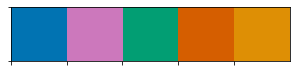

In [43]:
# get a custom colorblind pallete for full-size plots
# such that "all" color corresponds between full-size and small plots
custom_palette = sns.color_palette("colorblind",5)
tmp = custom_palette[4]
custom_palette[4] = custom_palette[1]
custom_palette[1] = tmp
sns.palplot(custom_palette)

In [44]:
# plot number of transcripts in each group
num_txs_strg_real = []
num_txs_slmn_real = []
num_txs_klst_real = []

num_txs_strg_splicing = []
num_txs_slmn_splicing = []
num_txs_klst_splicing = []

num_txs_strg_intronic = []
num_txs_slmn_intronic = []
num_txs_klst_intronic = []

num_txs_strg_intergenic = []
num_txs_slmn_intergenic = []
num_txs_klst_intergenic = []

num_txs_strg_all = []
num_txs_slmn_all = []
num_txs_klst_all = []

for i in range(len(fp_real)):
    num_txs_strg_real.append([len(fp_real[i][0]),len(tn_real[i][0]),len(fn_real[i][0]),len(tp_real[i][0])])
    num_txs_slmn_real.append([len(fp_real[i][1]),len(tn_real[i][1]),len(fn_real[i][1]),len(tp_real[i][1])])
    num_txs_klst_real.append([len(fp_real[i][2]),len(tn_real[i][2]),len(fn_real[i][2]),len(tp_real[i][2])])
    
    num_txs_strg_splicing.append([len(fp_splicing[i][0]),len(tn_splicing[i][0]),len(fn_splicing[i][0]),len(tp_splicing[i][0])])
    num_txs_slmn_splicing.append([len(fp_splicing[i][1]),len(tn_splicing[i][1]),len(fn_splicing[i][1]),len(tp_splicing[i][1])])
    num_txs_klst_splicing.append([len(fp_splicing[i][2]),len(tn_splicing[i][2]),len(fn_splicing[i][2]),len(tp_splicing[i][2])])
    
    num_txs_strg_intronic.append([len(fp_intronic[i][0]),len(tn_intronic[i][0]),len(fn_intronic[i][0]),len(tp_intronic[i][0])])
    num_txs_slmn_intronic.append([len(fp_intronic[i][1]),len(tn_intronic[i][1]),len(fn_intronic[i][1]),len(tp_intronic[i][1])])
    num_txs_klst_intronic.append([len(fp_intronic[i][2]),len(tn_intronic[i][2]),len(fn_intronic[i][2]),len(tp_intronic[i][2])])
    
    num_txs_strg_intergenic.append([len(fp_intergenic[i][0]),len(tn_intergenic[i][0]),len(fn_intergenic[i][0]),len(tp_intergenic[i][0])])
    num_txs_slmn_intergenic.append([len(fp_intergenic[i][1]),len(tn_intergenic[i][1]),len(fn_intergenic[i][1]),len(tp_intergenic[i][1])])
    num_txs_klst_intergenic.append([len(fp_intergenic[i][2]),len(tn_intergenic[i][2]),len(fn_intergenic[i][2]),len(tp_intergenic[i][2])])
    
    num_txs_strg_all.append([len(fp_all[i][0]),len(tn_all[i][0]),len(fn_all[i][0]),len(tp_all[i][0])])
    num_txs_slmn_all.append([len(fp_all[i][1]),len(tn_all[i][1]),len(fn_all[i][1]),len(tp_all[i][1])])
    num_txs_klst_all.append([len(fp_all[i][2]),len(tn_all[i][2]),len(fn_all[i][2]),len(tp_all[i][2])])


Text(0.5, 0, 'Number of Samples')

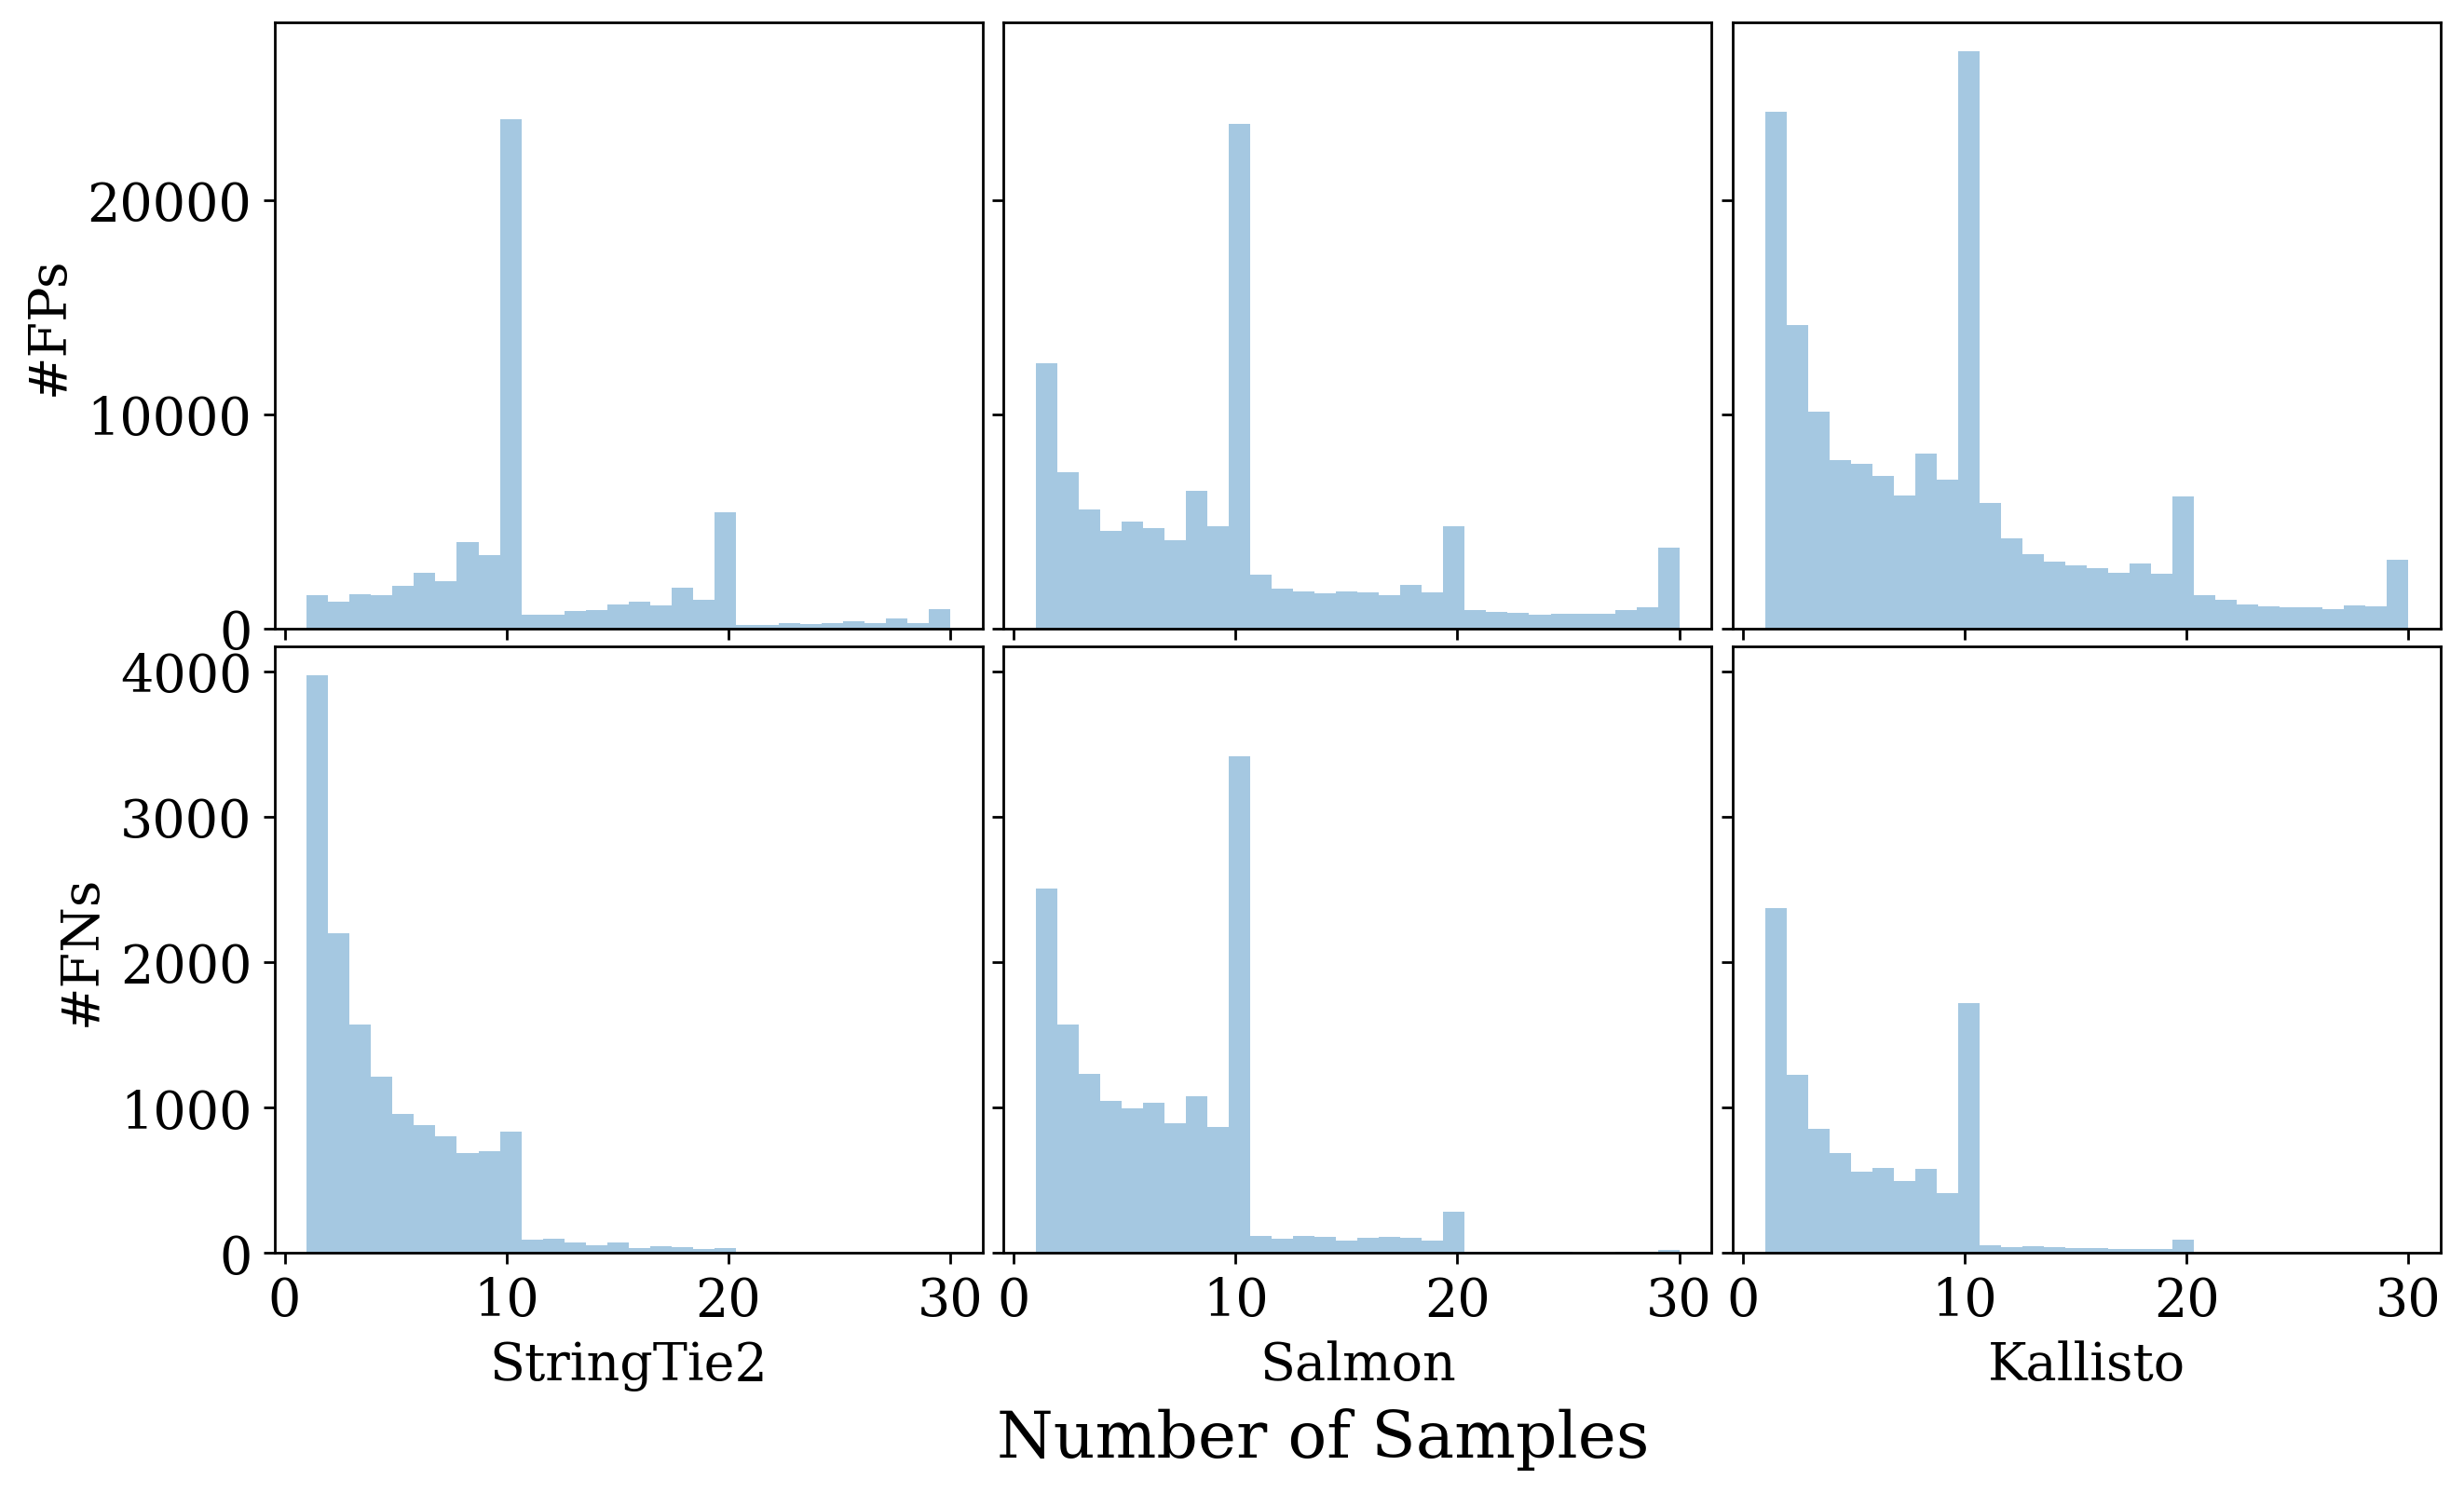

In [45]:
# get number of samples in which FPs and FNs occur
tx_fp_hist_strg = pd.DataFrame()
tx_fp_hist_slmn = pd.DataFrame()
tx_fp_hist_klst = pd.DataFrame()

for fp in fp_all:
    tx_fp_hist_strg = pd.concat([tx_fp_hist_strg,fp[0]])
    tx_fp_hist_slmn = pd.concat([tx_fp_hist_slmn,fp[1]])
    tx_fp_hist_klst = pd.concat([tx_fp_hist_klst,fp[2]])
    
tx_fn_hist_strg = pd.DataFrame()
tx_fn_hist_slmn = pd.DataFrame()
tx_fn_hist_klst = pd.DataFrame()

for fn in fn_all:
    tx_fn_hist_strg = pd.concat([tx_fn_hist_strg,fn[0][["tid","sim_cov"]]])
    tx_fn_hist_slmn = pd.concat([tx_fn_hist_slmn,fn[1][["tid","sim_cov"]]])
    tx_fn_hist_klst = pd.concat([tx_fn_hist_klst,fn[2][["tid","sim_cov"]]])
    
tx_fp_hist_strg = tx_fp_hist_strg.groupby(by="tid").count().reset_index()
tx_fp_hist_strg.columns = ["tid","count"]
tx_fp_hist_slmn = tx_fp_hist_slmn.groupby(by="tid").count().reset_index()
tx_fp_hist_slmn.columns = ["tid","count"]
tx_fp_hist_klst = tx_fp_hist_klst.groupby(by="tid").count().reset_index()
tx_fp_hist_klst.columns = ["tid","count"]


tx_fn_hist_strg = tx_fn_hist_strg.groupby(by="tid").count().reset_index()
tx_fn_hist_strg.columns = ["tid","count"]
tx_fn_hist_slmn = tx_fn_hist_slmn.groupby(by="tid").count().reset_index()
tx_fn_hist_slmn.columns = ["tid","count"]
tx_fn_hist_klst = tx_fn_hist_klst.groupby(by="tid").count().reset_index()
tx_fn_hist_klst.columns = ["tid","count"]



plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,7),sharex=True,sharey="row",gridspec_kw={'hspace':0.03,'wspace':0.03},dpi=250)

sns.distplot(tx_fp_hist_strg["count"],bins=30,kde=False,ax=axes[0][0])
sns.distplot(tx_fp_hist_slmn["count"],bins=30,kde=False,ax=axes[0][1])
sns.distplot(tx_fp_hist_klst["count"],bins=30,kde=False,ax=axes[0][2])

sns.distplot(tx_fn_hist_strg["count"],bins=30,kde=False,ax=axes[1][0])
sns.distplot(tx_fn_hist_slmn["count"],bins=30,kde=False,ax=axes[1][1])
sns.distplot(tx_fn_hist_klst["count"],bins=30,kde=False,ax=axes[1][2])

axes[0][0].set_ylabel("#FPs")
axes[1][0].set_ylabel("#FNs")

axes[1][0].set_xlabel("StringTie2")
axes[1][1].set_xlabel("Salmon")
axes[1][2].set_xlabel("Kallisto")
fig.text(0.5, 0, "Number of Samples", ha='center',fontsize=20)

In [46]:
# within a single tissue

num_single_tis_strg = len(tx_fp_hist_strg[tx_fp_hist_strg["count"]<=10])
num_all_strg = len(tx_fp_hist_strg)

num_single_tis_slmn = len(tx_fp_hist_slmn[tx_fp_hist_slmn["count"]<=10])
num_all_slmn = len(tx_fp_hist_slmn)

num_single_tis_klst = len(tx_fp_hist_klst[tx_fp_hist_klst["count"]<=10])
num_all_klst = len(tx_fp_hist_klst)

print((float(num_single_tis_strg)/float(num_all_strg)),
      (float(num_single_tis_slmn)/float(num_all_slmn)),
      (float(num_single_tis_klst)/float(num_all_klst)))

# FNs

num_single_tis_strg = len(tx_fn_hist_strg[tx_fn_hist_strg["count"]<=10])
num_all_strg = len(tx_fn_hist_strg)

num_single_tis_slmn = len(tx_fn_hist_slmn[tx_fn_hist_slmn["count"]<=10])
num_all_slmn = len(tx_fn_hist_slmn)

num_single_tis_klst = len(tx_fn_hist_klst[tx_fn_hist_klst["count"]<=10])
num_all_klst = len(tx_fn_hist_klst)

print((float(num_single_tis_strg)/float(num_all_strg)),
      (float(num_single_tis_slmn)/float(num_all_slmn)),
      (float(num_single_tis_klst)/float(num_all_klst)))

0.7056501436205209 0.7106606347968777 0.7043375087068935
0.9589174184594031 0.9186236343086777 0.9570001009387302


In [47]:
# within a single tissue

num_single_tis_strg = len(tx_fp_hist_strg[tx_fp_hist_strg["count"]==10])
num_all_strg = len(tx_fp_hist_strg)

num_single_tis_slmn = len(tx_fp_hist_slmn[tx_fp_hist_slmn["count"]==10])
num_all_slmn = len(tx_fp_hist_slmn)

num_single_tis_klst = len(tx_fp_hist_klst[tx_fp_hist_klst["count"]==10])
num_all_klst = len(tx_fp_hist_klst)

print((float(num_single_tis_strg)/float(num_all_strg)),
      (float(num_single_tis_slmn)/float(num_all_slmn)),
      (float(num_single_tis_klst)/float(num_all_klst)))
print(np.mean([(float(num_single_tis_strg)/float(num_all_strg)),
      (float(num_single_tis_slmn)/float(num_all_slmn)),
      (float(num_single_tis_klst)/float(num_all_klst))]))

# FNs

num_single_tis_strg = len(tx_fn_hist_strg[tx_fn_hist_strg["count"]==10])
num_all_strg = len(tx_fn_hist_strg)

num_single_tis_slmn = len(tx_fn_hist_slmn[tx_fn_hist_slmn["count"]==10])
num_all_slmn = len(tx_fn_hist_slmn)

num_single_tis_klst = len(tx_fn_hist_klst[tx_fn_hist_klst["count"]==10])
num_all_klst = len(tx_fn_hist_klst)

print((float(num_single_tis_strg)/float(num_all_strg)),
      (float(num_single_tis_slmn)/float(num_all_slmn)),
      (float(num_single_tis_klst)/float(num_all_klst)))
print(np.mean())

0.3813887061315532 0.21348467403425112 0.15906166251490503
0.25131168089356976
0.05773768216516308 0.21455481602411153 0.1737155546583224


TypeError: _mean_dispatcher() missing 1 required positional argument: 'a'

In [48]:
# now to compute false positive and false negative rates

tmp = pd.DataFrame(num_txs_strg_real,columns=["fp","tn","fn","tp"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df = tmp.copy(deep=True)
tmp = pd.DataFrame(num_txs_strg_splicing,columns=["fp","tn","fn","tp"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intronic,columns=["fp","tn","fn","tp"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_intergenic,columns=["fp","tn","fn","tp"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_strg_all,columns=["fp","tn","fn","tp"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_slmn_real,columns=["fp","tn","fn","tp"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_splicing,columns=["fp","tn","fn","tp"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intronic,columns=["fp","tn","fn","tp"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_intergenic,columns=["fp","tn","fn","tp"])
tmp["method"] = "Salmon"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_slmn_all,columns=["fp","tn","fn","tp"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(num_txs_klst_real,columns=["fp","tn","fn","tp"])
tmp["method"] = "kallisto"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_splicing,columns=["fp","tn","fn","tp"])
tmp["method"] = "kallisto"
tmp["type"] = "Real+Splicing"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intronic,columns=["fp","tn","fn","tp"])
tmp["method"] = "kallisto"
tmp["type"] = "Real+Intronic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_intergenic,columns=["fp","tn","fn","tp"])
tmp["method"] = "kallisto"
tmp["type"] = "Real+Intergenic"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(num_txs_klst_all,columns=["fp","tn","fn","tp"])
tmp["method"] = "kallisto"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

df.reset_index(drop=True)
df["fpr"] = df["fp"]/(df["fp"]+df["tn"])
df["fnr"] = df["fn"]/(df["fn"]+df["tp"])
df.head()

,fp,tn,fn,tp,method,type,fpr,fnr
0,22611,259393,1956,27805,StringTie2,Real,0.080180,0.065724
1,16346,272074,1541,21804,StringTie2,Real,0.056674,0.066010
2,16376,273206,2005,20178,StringTie2,Real,0.056550,0.090385
3,16844,270588,2144,22189,StringTie2,Real,0.058602,0.088111
4,22094,260319,2640,26712,StringTie2,Real,0.078233,0.089943


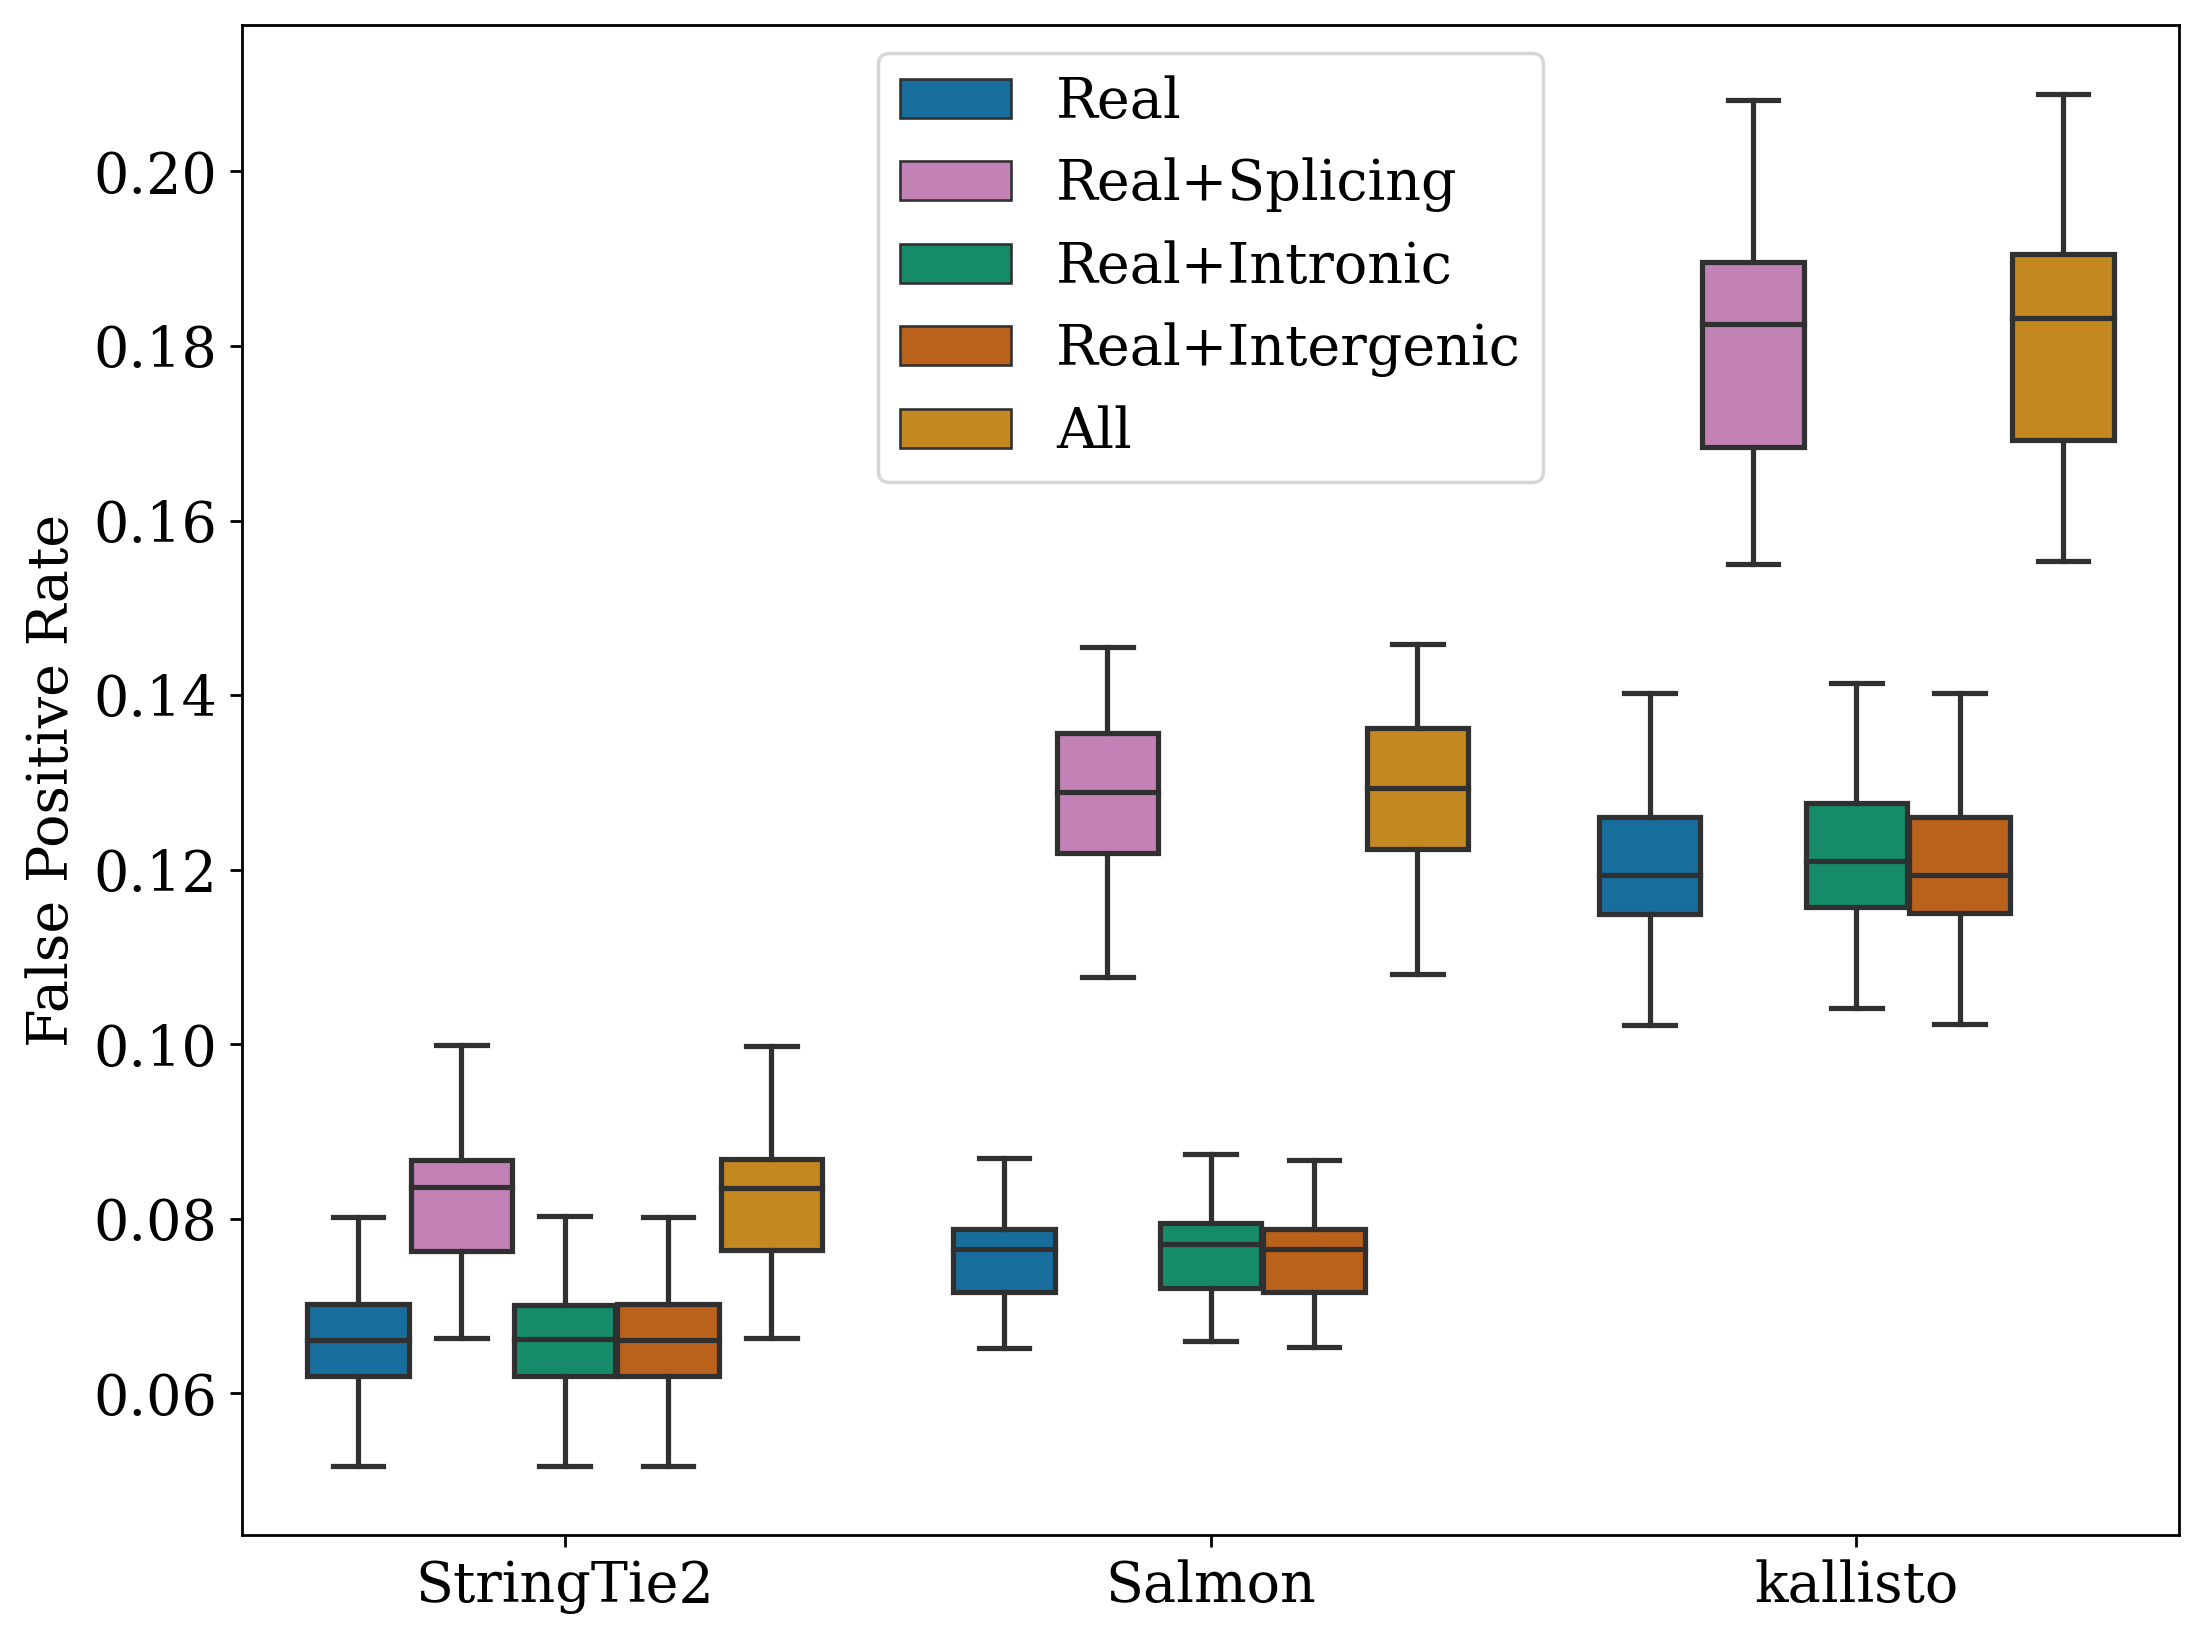

In [49]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="fpr",hue="type",data=df,palette=custom_palette)
# ax.set_title("Number of non-simulated transcripts (false positives) \n reported as expressed")
ax.set_xlabel("")
ax.set_ylabel("False Positive Rate")
legend = plt.legend(loc="upper center")
fig.savefig(fig_dir+"fpr_all.png", format='png')
plt.show()

In [50]:
for m in set(df["method"]):
    print(m)
    display(df[df["method"]==m].groupby("type").mean())

StringTie2


,fp,tn,fn,tp,fpr,fnr
type,,,,,,
All,23494.066667,262308.633333,2084.933333,23877.366667,0.082273,0.080013
Real,18844.200000,266958.500000,2108.533333,23853.766667,0.065989,0.080877
Real+Intergenic,18838.566667,266964.133333,2111.300000,23851.000000,0.065969,0.080980
Real+Intronic,18847.566667,266955.133333,2111.600000,23850.700000,0.066001,0.081010
Real+Splicing,23489.700000,262313.000000,2085.533333,23876.766667,0.082257,0.080029


kallisto


,fp,tn,fn,tp,fpr,fnr
type,,,,,,
All,51478.166667,234324.533333,1741.100000,24221.200000,0.180201,0.066744
Real,34316.200000,251486.500000,1232.766667,24729.533333,0.120128,0.047252
Real+Intergenic,34336.633333,251466.066667,1232.800000,24729.500000,0.120199,0.047253
Real+Intronic,34673.266667,251129.433333,1233.966667,24728.333333,0.121377,0.047305
Real+Splicing,51280.333333,234522.366667,1739.600000,24222.700000,0.179509,0.066685


Salmon


,fp,tn,fn,tp,fpr,fnr
type,,,,,,
All,36677.033333,249125.666667,3439.266667,22523.033333,0.128388,0.131980
Real,21546.366667,264256.333333,3060.766667,22901.533333,0.075422,0.117453
Real+Intergenic,21548.733333,264253.966667,3063.066667,22899.233333,0.075431,0.117551
Real+Intronic,21728.800000,264073.900000,3064.600000,22897.700000,0.076061,0.117600
Real+Splicing,36576.366667,249226.333333,3438.900000,22523.400000,0.128036,0.131970


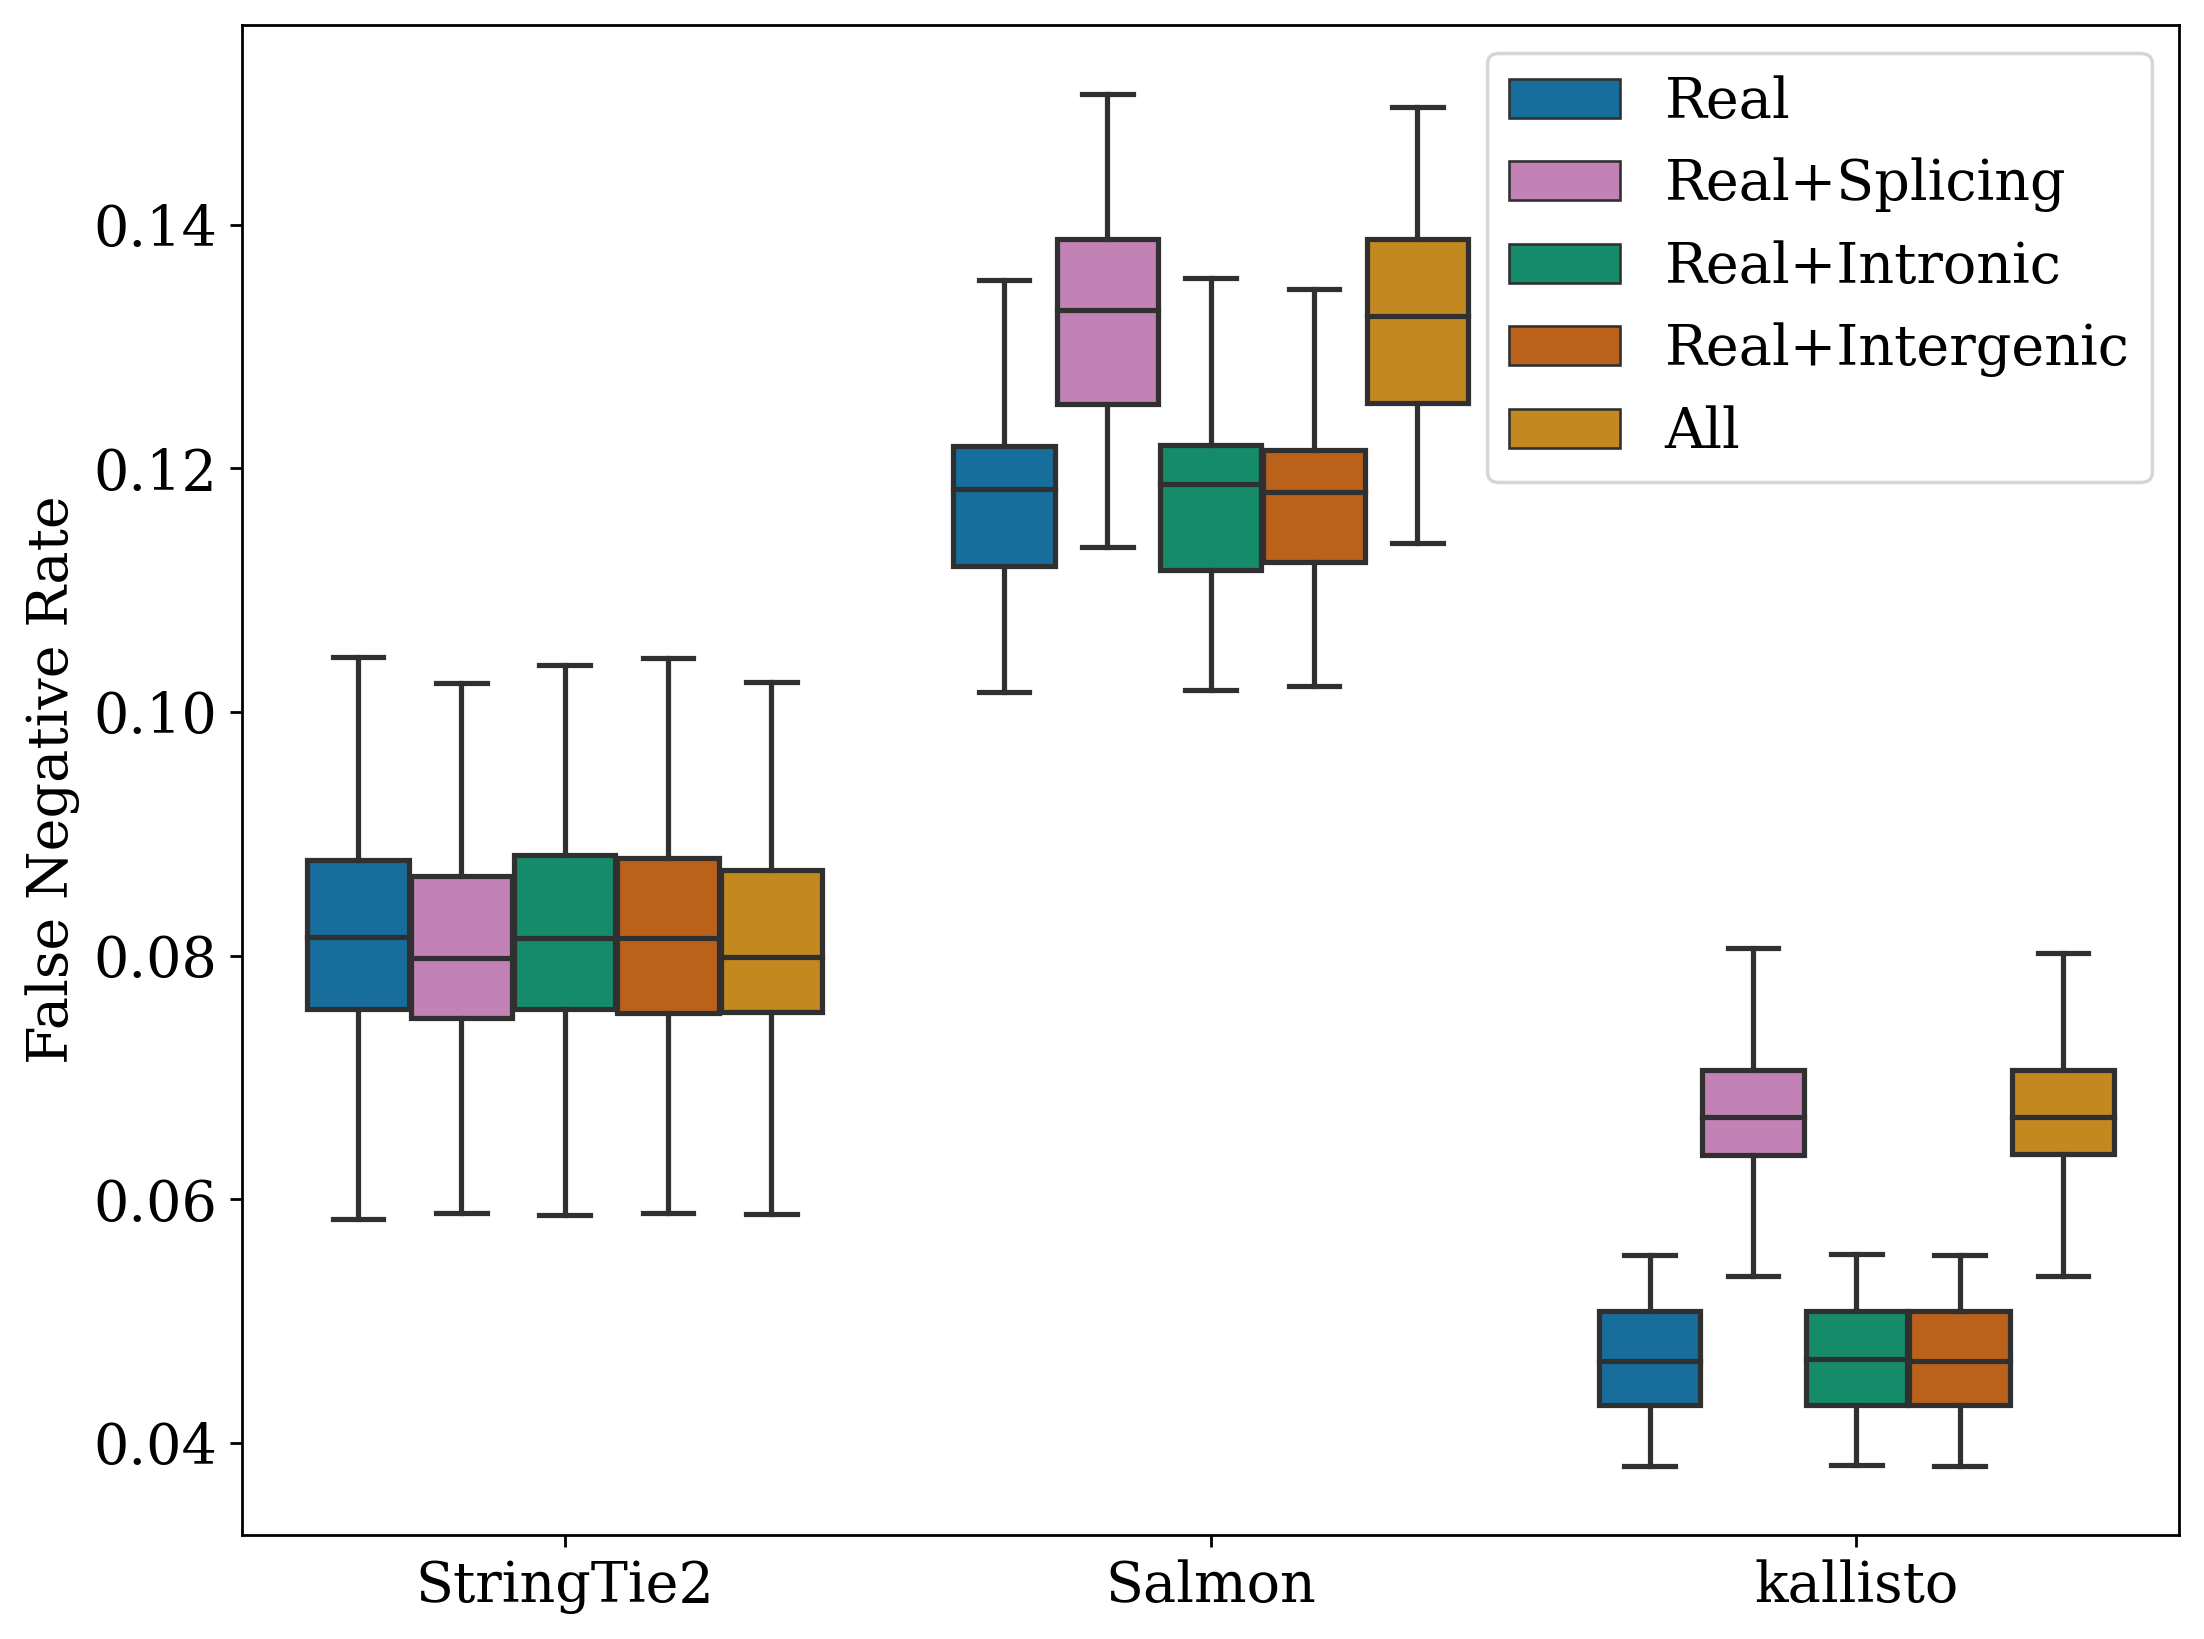

In [51]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="fnr",hue="type",data=df,palette=custom_palette)
# ax.set_title("Number of non-simulated transcripts (false positives) \n reported as expressed")
ax.set_xlabel("")
ax.set_ylabel("False Negative Rate")
legend = plt.legend(loc="upper right")
fig.savefig(fig_dir+"fnr_all.png", format='png')
plt.show()

In [ ]:
# now need to also get FPR and FNR for genes

In [ ]:
for tn in range(num_tissues):
    for sn in range(num_samples):
        print("\n=================\nTissue #"+str(tn)+" - Sample #"+str(sn)+"\n=================\n")
        tx_nr = dict()

        # first we need to get the number of simulated reads per each gene for each group
        with open(out_dir+"all.t"+str(tn)+"_s"+str(sn)+"/sample_01.shuffled.fasta","r") as inFP:
            for line in inFP.readlines():
                if line[0]==">":
                    tid = line.split("/")[1].split(";")[0]
                    tx_nr[tid] = tx_nr.setdefault(tid,0)+1

        print("loaded fasta")

        # now build respective dataframes
        counts = pd.DataFrame(tx_nr,index=[0]).T.reset_index()
        counts.columns = ["tid","nr"]

        # now need to load the base GTF to link intronic and splicing reads to the respective genes
        real = pd.read_csv(out_dir+"real.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
        real = real[real["type"]=="transcript"].reset_index(drop=True)
        real["gid"] = real["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        real["tid"] = real["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        real = real[["gid","tid"]]
        real["type"] = "real"

        splicing = pd.read_csv(out_dir+"splicing.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
        splicing = splicing[splicing["type"]=="transcript"].reset_index(drop=True)
        splicing["gid"] = splicing["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing["tid"] = splicing["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        splicing = splicing[["gid","tid"]]
        splicing["type"] = "noise"

        intronic = pd.read_csv(out_dir+"intronic.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
        intronic = intronic[intronic["type"]=="transcript"].reset_index(drop=True)
        intronic["gid"] = intronic["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic["tid"] = intronic["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intronic = intronic[["gid","tid"]]
        intronic["type"] = "noise"

        intergenic = pd.read_csv(out_dir+"intergenic.t"+str(tn)+"_s"+str(sn)+".gtf",sep="\t",names=gff3cols)
        intergenic = intergenic[intergenic["type"]=="transcript"].reset_index(drop=True)
        intergenic["gid"] = intergenic["attributes"].str.split("gene_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic["tid"] = intergenic["attributes"].str.split("transcript_id \"",expand=True,n=1)[1].str.split("\"",expand=True,n=1)[0]
        intergenic = intergenic[["gid","tid"]]
        intergenic["type"] = "noise"

        print("loaded gtf")

        # aggregate the 
        all_df = pd.concat([real,splicing,intronic,intergenic],axis=0)

        # now need to add counts to the transcripts
        all_df = all_df.merge(counts,how="outer",indicator=True,on="tid")
        assert len(all_df[all_df["_merge"]=="right_only"])==0,"unidentified transcripts found"
        all_df.dropna(axis=0,inplace=True)
        all_df.drop(["_merge","tid"],axis=1,inplace=True)

        print("added counts")

        # now need to aggregate the results by gene and type
        all_df = all_df.groupby(by=["gid","type"]).sum().reset_index()

        real = all_df[all_df["type"]=="real"].reset_index(drop=True)
        real.drop("type",axis=1,inplace=True)
        real.columns = ["gid","nr_real"]
        noise = all_df[all_df["type"]=="noise"].reset_index(drop=True)
        noise.drop("type",axis=1,inplace=True)
        noise.columns = ["gid","nr_noise"]
        all_df = real.merge(noise,how="outer",on="gid")

        all_df.replace(np.nan,0,inplace=True)
        all_df["nr_total"] = all_df["nr_real"]+all_df["nr_noise"]
        all_df["frac_real"] = all_df["nr_real"]/all_df["nr_total"]

        print("aggregated")

        # now need to load the results
        res_real = pd.read_csv(out_dir+"real.t"+str(tn)+"_s"+str(sn)+".res")
        # again need to aggregate the res_realults for gene level
        res_real["gid"] = "CHS."+res_real["tid"].str.split(".",expand=True)[1]
        res_real = res_real[["gid","sim_nreads","strg_nreads","slmn_nreads","klst_nreads"]]
        res_real = res_real.groupby(by="gid").sum().reset_index()
        res_real.columns = ["gid","sim_nreads","strg_nreads_real","slmn_nreads_real","klst_nreads_real"]

        res_all = pd.read_csv(out_dir+"all.t"+str(tn)+"_s"+str(sn)+".res")
        # again need to aggregate the res_allults for gene level
        res_all["gid"] = "CHS."+res_all["tid"].str.split(".",expand=True)[1]
        res_all = res_all[["gid","sim_nreads","strg_nreads","slmn_nreads","klst_nreads"]]
        res_all = res_all.groupby(by="gid").sum().reset_index()
        res_all.columns = ["gid","sim_nreads_all","strg_nreads_all","slmn_nreads_all","klst_nreads_all"]


        # now we can combine this data with the fractions
        res = res_real.merge(res_all,how="outer",on="gid",indicator=True)
        assert len(res[res["_merge"]=="both"])==len(res),"unidentified genes"
        assert len(res[res["sim_nreads"]==res["sim_nreads_all"]])==len(res),"non-matching number of reads"
        res.drop(["sim_nreads_all","_merge"],axis=1,inplace=True)

        print("combined")

        # now we can separate false positives and false negatives
        fp_strg_real = res[(res["sim_nreads"]==0)&(res["strg_nreads_real"]>0)].reset_index(drop=True)
        fp_slmn_real = res[(res["sim_nreads"]==0)&(res["slmn_nreads_real"]>0)].reset_index(drop=True)
        fp_klst_real = res[(res["sim_nreads"]==0)&(res["klst_nreads_real"]>0)].reset_index(drop=True)

        fp_strg_all = res[(res["sim_nreads"]==0)&(res["strg_nreads_all"]>0)].reset_index(drop=True)
        fp_slmn_all = res[(res["sim_nreads"]==0)&(res["slmn_nreads_all"]>0)].reset_index(drop=True)
        fp_klst_all = res[(res["sim_nreads"]==0)&(res["klst_nreads_all"]>0)].reset_index(drop=True)

        fn_strg_real = res[(res["sim_nreads"]>0)&(res["strg_nreads_real"]==0)].reset_index(drop=True)
        fn_slmn_real = res[(res["sim_nreads"]>0)&(res["slmn_nreads_real"]==0)].reset_index(drop=True)
        fn_klst_real = res[(res["sim_nreads"]>0)&(res["klst_nreads_real"]==0)].reset_index(drop=True)

        fn_strg_all = res[(res["sim_nreads"]>0)&(res["strg_nreads_all"]==0)].reset_index(drop=True)
        fn_slmn_all = res[(res["sim_nreads"]>0)&(res["slmn_nreads_all"]==0)].reset_index(drop=True)
        fn_klst_all = res[(res["sim_nreads"]>0)&(res["klst_nreads_all"]==0)].reset_index(drop=True)

        tn_strg_real = res[(res["sim_nreads"]==0)&(res["strg_nreads_real"]==0)].reset_index(drop=True)
        tn_slmn_real = res[(res["sim_nreads"]==0)&(res["slmn_nreads_real"]==0)].reset_index(drop=True)
        tn_klst_real = res[(res["sim_nreads"]==0)&(res["klst_nreads_real"]==0)].reset_index(drop=True)

        tn_strg_all = res[(res["sim_nreads"]==0)&(res["strg_nreads_all"]==0)].reset_index(drop=True)
        tn_slmn_all = res[(res["sim_nreads"]==0)&(res["slmn_nreads_all"]==0)].reset_index(drop=True)
        tn_klst_all = res[(res["sim_nreads"]==0)&(res["klst_nreads_all"]==0)].reset_index(drop=True)

        tp_strg_real = res[(res["sim_nreads"]>0)&(res["strg_nreads_real"]>0)].reset_index(drop=True)
        tp_slmn_real = res[(res["sim_nreads"]>0)&(res["slmn_nreads_real"]>0)].reset_index(drop=True)
        tp_klst_real = res[(res["sim_nreads"]>0)&(res["klst_nreads_real"]>0)].reset_index(drop=True)

        tp_strg_all = res[(res["sim_nreads"]>0)&(res["strg_nreads_all"]>0)].reset_index(drop=True)
        tp_slmn_all = res[(res["sim_nreads"]>0)&(res["slmn_nreads_all"]>0)].reset_index(drop=True)
        tp_klst_all = res[(res["sim_nreads"]>0)&(res["klst_nreads_all"]>0)].reset_index(drop=True)

        tp_strg_real.to_csv(out_dir+"tp_strg_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        tp_slmn_real.to_csv(out_dir+"tp_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        tp_klst_real.to_csv(out_dir+"tp_klst_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        tp_strg_all.to_csv(out_dir+"tp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        tp_slmn_all.to_csv(out_dir+"tp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        tp_klst_all.to_csv(out_dir+"tp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        tn_strg_real.to_csv(out_dir+"tn_strg_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        tn_slmn_real.to_csv(out_dir+"tn_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        tn_klst_real.to_csv(out_dir+"tn_klst_real.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

        tn_strg_all.to_csv(out_dir+"tn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        tn_slmn_all.to_csv(out_dir+"tn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)
        tn_klst_all.to_csv(out_dir+"tn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv",index=False)

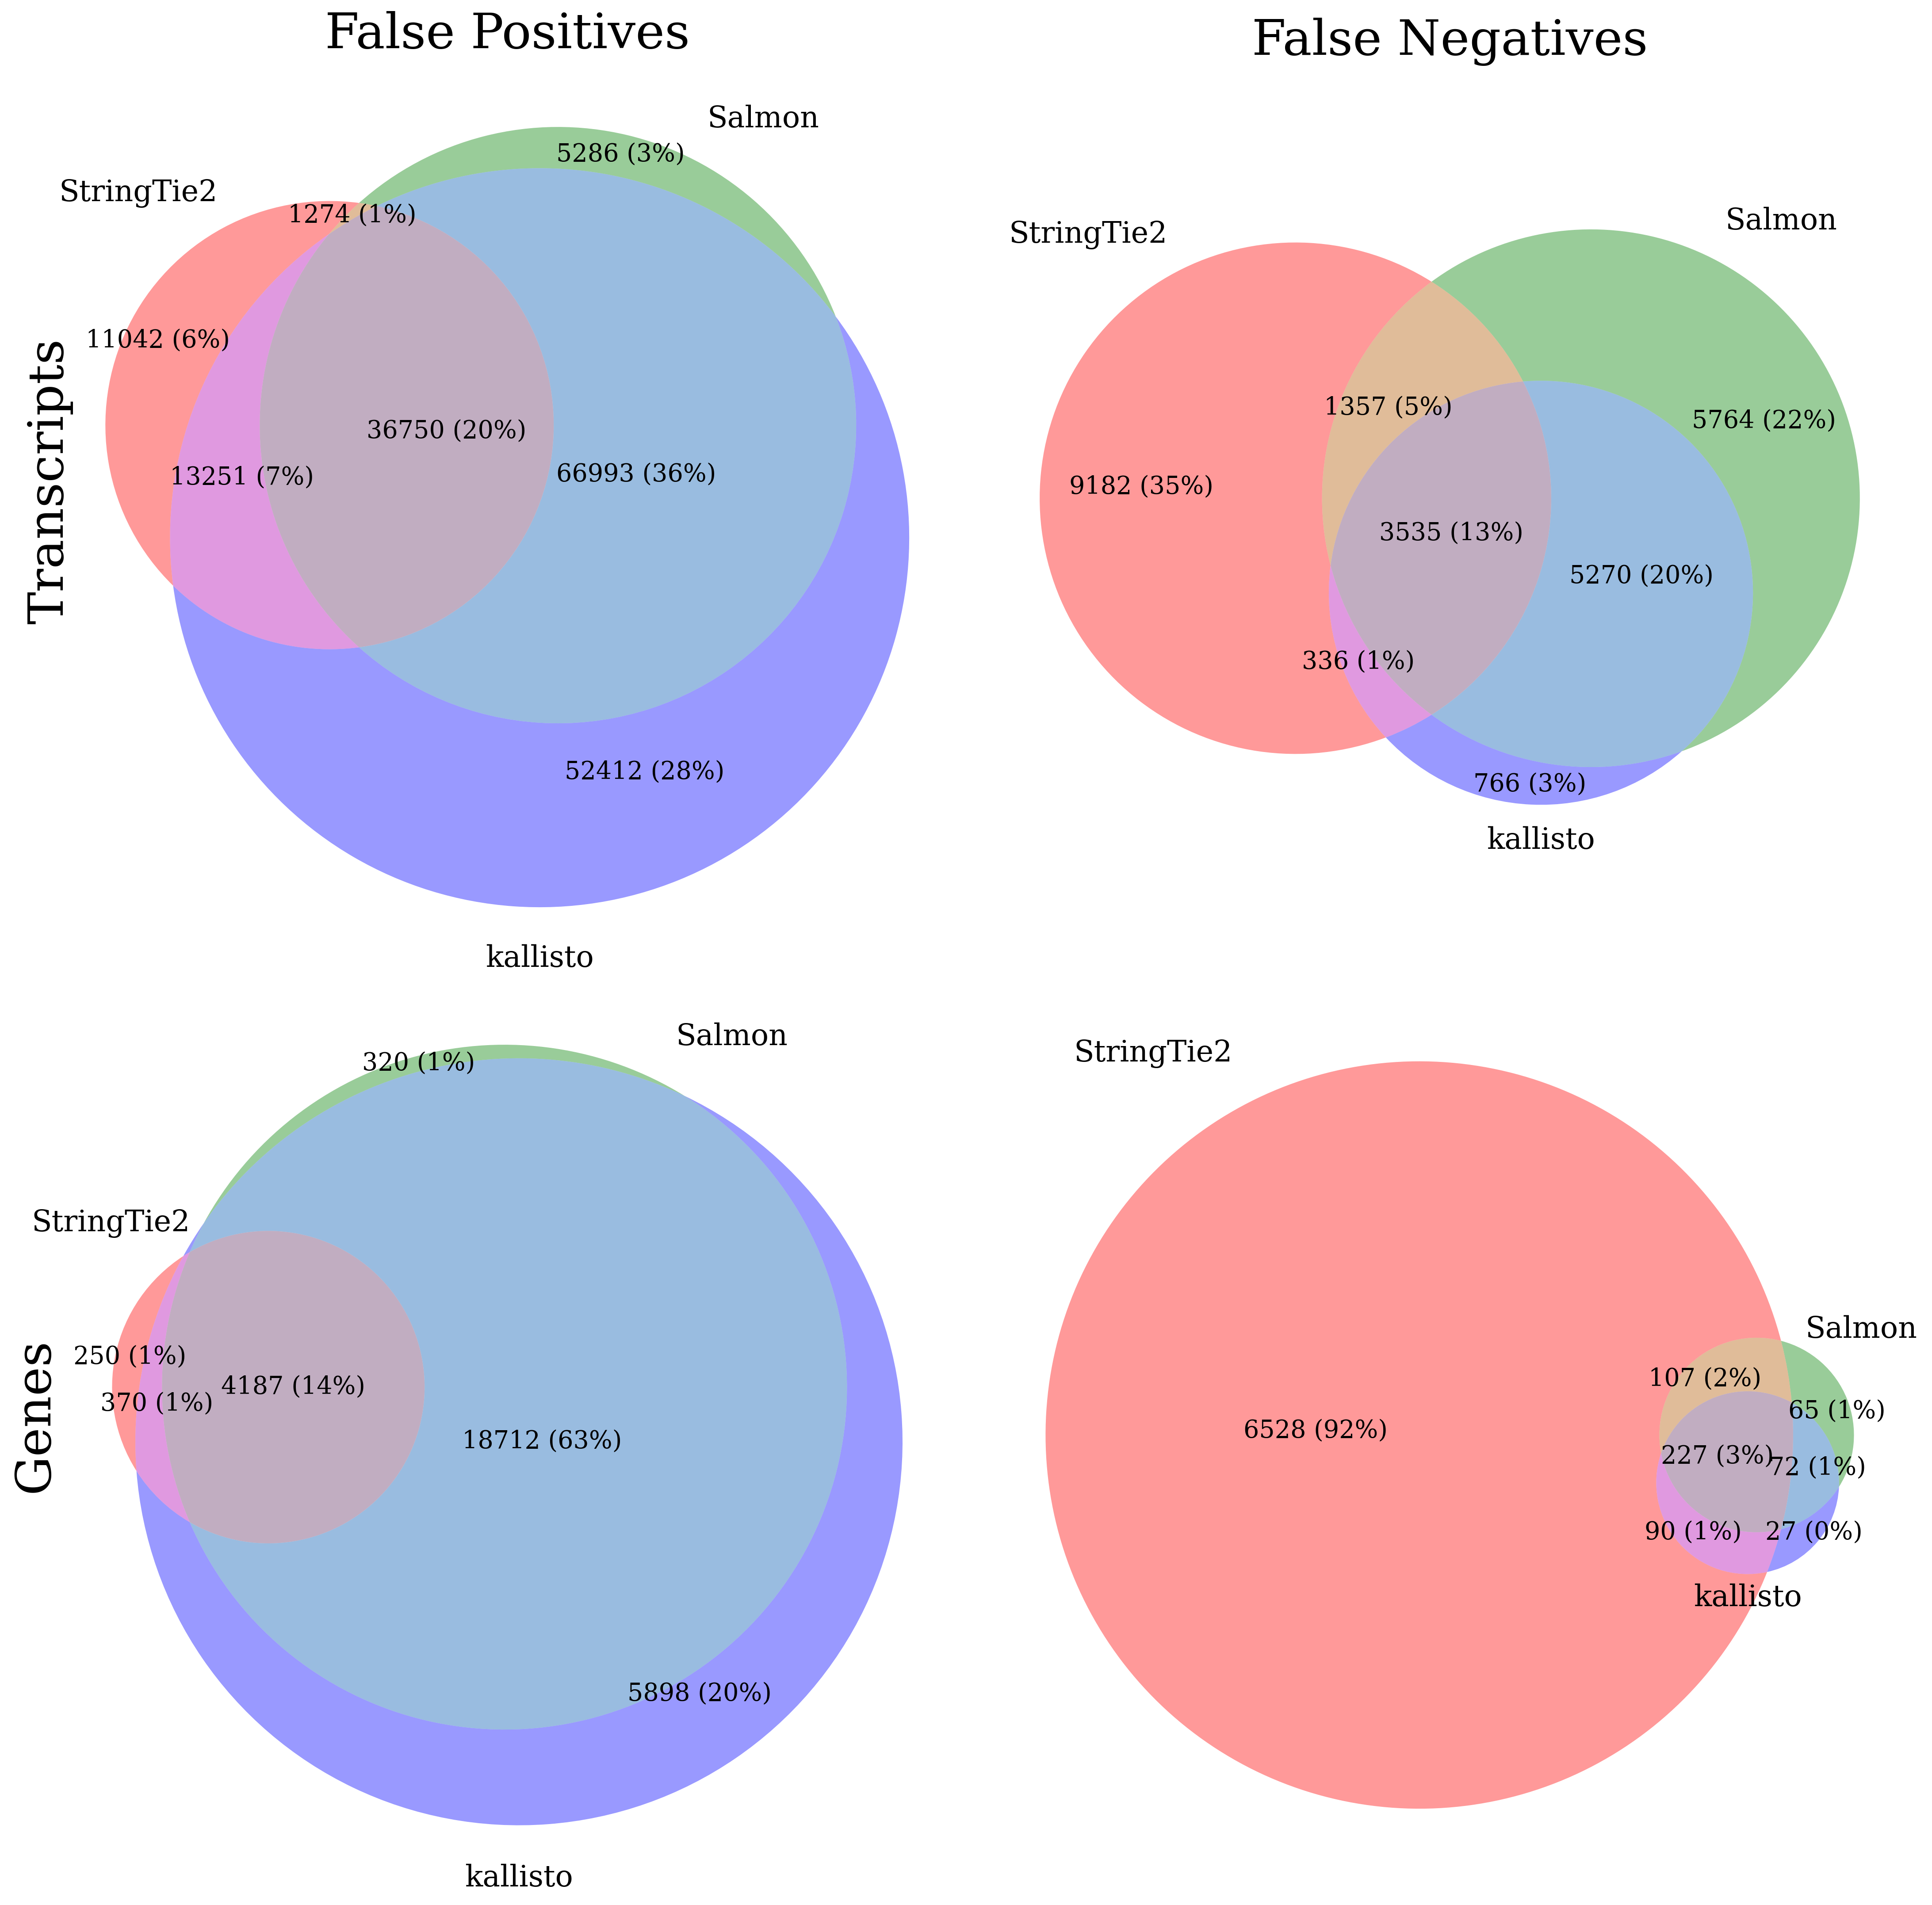

In [52]:
# venn diagram of FP overlap between methods
tx_fp_strg = set()
tx_fp_slmn = set()
tx_fp_klst = set()

tx_fn_strg = set()
tx_fn_slmn = set()
tx_fn_klst = set()

gn_fp_strg = set()
gn_fp_slmn = set()
gn_fp_klst = set()

gn_fn_strg = set()
gn_fn_slmn = set()
gn_fn_klst = set()

for tn in range(num_tissues):
    for sn in range(num_samples):
        tmp = pd.read_csv(out_dir+"all.t"+str(tn)+"_s"+str(sn)+".res")
        tx_fp_strg = tx_fp_strg.union(set(tmp[(tmp["sim_tpm"]==0)&(tmp["strg_tpm"]>0)]["tid"]))
        tx_fp_slmn = tx_fp_slmn.union(set(tmp[(tmp["sim_tpm"]==0)&(tmp["slmn_tpm"]>0)]["tid"]))
        tx_fp_klst = tx_fp_klst.union(set(tmp[(tmp["sim_tpm"]==0)&(tmp["klst_tpm"]>0)]["tid"]))
        
        tx_fn_strg = tx_fn_strg.union(set(tmp[(tmp["sim_tpm"]>0)&(tmp["strg_tpm"]==0)]["tid"]))
        tx_fn_slmn = tx_fn_slmn.union(set(tmp[(tmp["sim_tpm"]>0)&(tmp["slmn_tpm"]==0)]["tid"]))
        tx_fn_klst = tx_fn_klst.union(set(tmp[(tmp["sim_tpm"]>0)&(tmp["klst_tpm"]==0)]["tid"]))
        
        gn_fp_strg = gn_fp_strg.union(set(pd.read_csv(out_dir+"fp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"]))
        gn_fp_slmn = gn_fp_slmn.union(set(pd.read_csv(out_dir+"fp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"]))
        gn_fp_klst = gn_fp_klst.union(set(pd.read_csv(out_dir+"fp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"]))
        
        gn_fn_strg = gn_fn_strg.union(set(pd.read_csv(out_dir+"fn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"]))
        gn_fn_slmn = gn_fn_slmn.union(set(pd.read_csv(out_dir+"fn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"]))
        gn_fn_klst = gn_fn_klst.union(set(pd.read_csv(out_dir+"fn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"]))
        
tx_fp_all = tx_fp_strg.union(tx_fp_slmn.union(tx_fp_klst))
tx_fn_all = tx_fn_strg.union(tx_fn_slmn.union(tx_fn_klst))

gn_fp_all = gn_fp_strg.union(gn_fp_slmn.union(gn_fp_klst))
gn_fn_all = gn_fn_strg.union(gn_fn_slmn.union(gn_fn_klst))

plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(22,22),gridspec_kw={'hspace':0,'wspace':0},dpi=250)

labels = ("StringTie2","Salmon","kallisto")

v = venn3([tx_fp_strg,tx_fp_slmn,tx_fp_klst],set_labels=labels,subset_label_formatter=lambda x: str(x)+" ("+f"{(x/len(tx_fp_all)):1.0%}"+")",ax=axes[0][0])
axes[0][0].set_title("False Positives",fontsize=32)
axes[0][0].text(-0.7,0, 'Transcripts', va='center', rotation='vertical',fontsize=32)

venn3([tx_fn_strg,tx_fn_slmn,tx_fn_klst],set_labels=labels,subset_label_formatter=lambda x: str(x)+" ("+f"{(x/len(tx_fn_all)):1.0%}"+")",ax=axes[0][1])
axes[0][1].set_title("False Negatives",y=1.15,fontsize=32)

venn3([gn_fp_strg,gn_fp_slmn,gn_fp_klst],set_labels=labels,subset_label_formatter=lambda x: str(x)+" ("+f"{(x/len(gn_fp_all)):1.0%}"+")",ax=axes[1][0])
axes[1][0].text(-0.7,0, 'Genes', va='center', rotation='vertical',fontsize=32)

venn3([gn_fn_strg,gn_fn_slmn,gn_fn_klst],set_labels=labels,subset_label_formatter=lambda x: str(x)+" ("+f"{(x/len(gn_fn_all)):1.0%}"+")",ax=axes[1][1])

plt.show()

In [53]:
# now we need to compute same but with average overlaps
strg_only_tx_fp = list()
slmn_only_tx_fp = list()
klst_only_tx_fp = list()
strg_slmn_tx_fp = list()
strg_klst_tx_fp = list()
slmn_klst_tx_fp = list()
strg_slmn_klst_tx_fp = list()

strg_only_tx_fn = list()
slmn_only_tx_fn = list()
klst_only_tx_fn = list()
strg_slmn_tx_fn = list()
strg_klst_tx_fn = list()
slmn_klst_tx_fn = list()
strg_slmn_klst_tx_fn = list()

strg_only_gn_fp = list()
slmn_only_gn_fp = list()
klst_only_gn_fp = list()
strg_slmn_gn_fp = list()
strg_klst_gn_fp = list()
slmn_klst_gn_fp = list()
strg_slmn_klst_gn_fp = list()

strg_only_gn_fn = list()
slmn_only_gn_fn = list()
klst_only_gn_fn = list()
strg_slmn_gn_fn = list()
strg_klst_gn_fn = list()
slmn_klst_gn_fn = list()
strg_slmn_klst_gn_fn = list()

for tn in range(num_tissues):
    for sn in range(num_samples):
        # load individual sets
        tmp = pd.read_csv(out_dir+"all.t"+str(tn)+"_s"+str(sn)+".res")
        tx_fp_strg = set(tmp[(tmp["sim_tpm"]==0)&(tmp["strg_tpm"]>0)]["tid"])
        tx_fp_slmn = set(tmp[(tmp["sim_tpm"]==0)&(tmp["slmn_tpm"]>0)]["tid"])
        tx_fp_klst = set(tmp[(tmp["sim_tpm"]==0)&(tmp["klst_tpm"]>0)]["tid"])
        
        tx_fn_strg = set(tmp[(tmp["sim_tpm"]>0)&(tmp["strg_tpm"]==0)]["tid"])
        tx_fn_slmn = set(tmp[(tmp["sim_tpm"]>0)&(tmp["slmn_tpm"]==0)]["tid"])
        tx_fn_klst = set(tmp[(tmp["sim_tpm"]>0)&(tmp["klst_tpm"]==0)]["tid"])
        
        gn_fp_strg = set(pd.read_csv(out_dir+"fp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"])
        gn_fp_slmn = set(pd.read_csv(out_dir+"fp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"])
        gn_fp_klst = set(pd.read_csv(out_dir+"fp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"])
        
        gn_fn_strg = set(pd.read_csv(out_dir+"fn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"])
        gn_fn_slmn = set(pd.read_csv(out_dir+"fn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"])
        gn_fn_klst = set(pd.read_csv(out_dir+"fn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")["gid"])
        
        
        # compute overlaps
        strg_slmn_klst_tx_fp.append(len(tx_fp_strg & tx_fp_slmn & tx_fp_klst))
        strg_slmn_klst_tx_fn.append(len(tx_fn_strg & tx_fn_slmn & tx_fn_klst))
        strg_slmn_klst_gn_fp.append(len(gn_fp_strg & gn_fp_slmn & gn_fp_klst))
        strg_slmn_klst_gn_fn.append(len(gn_fn_strg & gn_fn_slmn & gn_fn_klst))
        
        strg_only_tx_fp.append(len((tx_fp_strg-tx_fp_slmn)-tx_fp_klst))
        strg_only_tx_fn.append(len((tx_fn_strg-tx_fn_slmn)-tx_fn_klst))
        strg_only_gn_fp.append(len((gn_fp_strg-gn_fp_slmn)-gn_fp_klst))
        strg_only_gn_fn.append(len((gn_fn_strg-gn_fn_slmn)-gn_fn_klst))
        
        slmn_only_tx_fp.append(len((tx_fp_slmn-tx_fp_strg)-tx_fp_klst))
        slmn_only_tx_fn.append(len((tx_fn_slmn-tx_fn_strg)-tx_fn_klst))
        slmn_only_gn_fp.append(len((gn_fp_slmn-gn_fp_strg)-gn_fp_klst))
        slmn_only_gn_fn.append(len((gn_fn_slmn-gn_fn_strg)-gn_fn_klst))
        
        klst_only_tx_fp.append(len((tx_fp_klst-tx_fp_slmn)-tx_fp_strg))
        klst_only_tx_fn.append(len((tx_fn_klst-tx_fn_slmn)-tx_fn_strg))
        klst_only_gn_fp.append(len((gn_fp_klst-gn_fp_slmn)-gn_fp_strg))
        klst_only_gn_fn.append(len((gn_fn_klst-gn_fn_slmn)-gn_fn_strg))
        
        strg_slmn_tx_fp.append(len((tx_fp_strg&tx_fp_slmn)-tx_fp_klst))
        strg_klst_tx_fp.append(len((tx_fp_strg&tx_fp_klst)-tx_fp_slmn))
        slmn_klst_tx_fp.append(len((tx_fp_klst&tx_fp_slmn)-tx_fp_strg))
        
        strg_slmn_tx_fn.append(len((tx_fn_strg&tx_fn_slmn)-tx_fn_klst))
        strg_klst_tx_fn.append(len((tx_fn_strg&tx_fn_klst)-tx_fn_slmn))
        slmn_klst_tx_fn.append(len((tx_fn_klst&tx_fn_slmn)-tx_fn_strg))
        
        strg_slmn_gn_fp.append(len((gn_fp_strg&gn_fp_slmn)-gn_fp_klst))
        strg_klst_gn_fp.append(len((gn_fp_strg&gn_fp_klst)-gn_fp_slmn))
        slmn_klst_gn_fp.append(len((gn_fp_klst&gn_fp_slmn)-gn_fp_strg))
        
        strg_slmn_gn_fn.append(len((gn_fn_strg&gn_fn_slmn)-gn_fn_klst))
        strg_klst_gn_fn.append(len((gn_fn_strg&gn_fn_klst)-gn_fn_slmn))
        slmn_klst_gn_fn.append(len((gn_fn_klst&gn_fn_slmn)-gn_fn_strg))

In [54]:
# averages
strg_only_tx_fp_avg = int(round(np.mean(strg_only_tx_fp),0))
slmn_only_tx_fp_avg = int(round(np.mean(slmn_only_tx_fp),0))
klst_only_tx_fp_avg = int(round(np.mean(klst_only_tx_fp),0))
strg_slmn_tx_fp_avg = int(round(np.mean(strg_slmn_tx_fp),0))
strg_klst_tx_fp_avg = int(round(np.mean(strg_klst_tx_fp),0))
slmn_klst_tx_fp_avg = int(round(np.mean(slmn_klst_tx_fp),0))
strg_slmn_klst_tx_fp_avg = int(round(np.mean(strg_slmn_klst_tx_fp),0))
tx_fp_sum = sum([strg_only_tx_fp_avg,slmn_only_tx_fp_avg,klst_only_tx_fp_avg,strg_slmn_tx_fp_avg,strg_klst_tx_fp_avg,slmn_klst_tx_fp_avg,strg_slmn_klst_tx_fp_avg])

strg_only_tx_fn_avg = int(round(np.mean(strg_only_tx_fn),0))
slmn_only_tx_fn_avg = int(round(np.mean(slmn_only_tx_fn),0))
klst_only_tx_fn_avg = int(round(np.mean(klst_only_tx_fn),0))
strg_slmn_tx_fn_avg = int(round(np.mean(strg_slmn_tx_fn),0))
strg_klst_tx_fn_avg = int(round(np.mean(strg_klst_tx_fn),0))
slmn_klst_tx_fn_avg = int(round(np.mean(slmn_klst_tx_fn),0))
strg_slmn_klst_tx_fn_avg = int(round(np.mean(strg_slmn_klst_tx_fn),0))
tx_fn_sum = sum([strg_only_tx_fn_avg,slmn_only_tx_fn_avg,klst_only_tx_fn_avg,strg_slmn_tx_fn_avg,strg_klst_tx_fn_avg,slmn_klst_tx_fn_avg,strg_slmn_klst_tx_fn_avg])

strg_only_gn_fp_avg = int(round(np.mean(strg_only_gn_fp),0))
slmn_only_gn_fp_avg = int(round(np.mean(slmn_only_gn_fp),0))
klst_only_gn_fp_avg = int(round(np.mean(klst_only_gn_fp),0))
strg_slmn_gn_fp_avg = int(round(np.mean(strg_slmn_gn_fp),0))
strg_klst_gn_fp_avg = int(round(np.mean(strg_klst_gn_fp),0))
slmn_klst_gn_fp_avg = int(round(np.mean(slmn_klst_gn_fp),0))
strg_slmn_klst_gn_fp_avg = int(round(np.mean(strg_slmn_klst_gn_fp),0))
gn_fp_sum = sum([strg_only_gn_fp_avg,slmn_only_gn_fp_avg,klst_only_gn_fp_avg,strg_slmn_gn_fp_avg,strg_klst_gn_fp_avg,slmn_klst_gn_fp_avg,strg_slmn_klst_gn_fp_avg])

strg_only_gn_fn_avg = int(round(np.mean(strg_only_gn_fn),0))
slmn_only_gn_fn_avg = int(round(np.mean(slmn_only_gn_fn),0))
klst_only_gn_fn_avg = int(round(np.mean(klst_only_gn_fn),0))
strg_slmn_gn_fn_avg = int(round(np.mean(strg_slmn_gn_fn),0))
strg_klst_gn_fn_avg = int(round(np.mean(strg_klst_gn_fn),0))
slmn_klst_gn_fn_avg = int(round(np.mean(slmn_klst_gn_fn),0))
strg_slmn_klst_gn_fn_avg = int(round(np.mean(strg_slmn_klst_gn_fn),0))
gn_fn_sum = sum([strg_only_gn_fn_avg,slmn_only_gn_fn_avg,klst_only_gn_fn_avg,strg_slmn_gn_fn_avg,strg_klst_gn_fn_avg,slmn_klst_gn_fn_avg,strg_slmn_klst_gn_fn_avg])

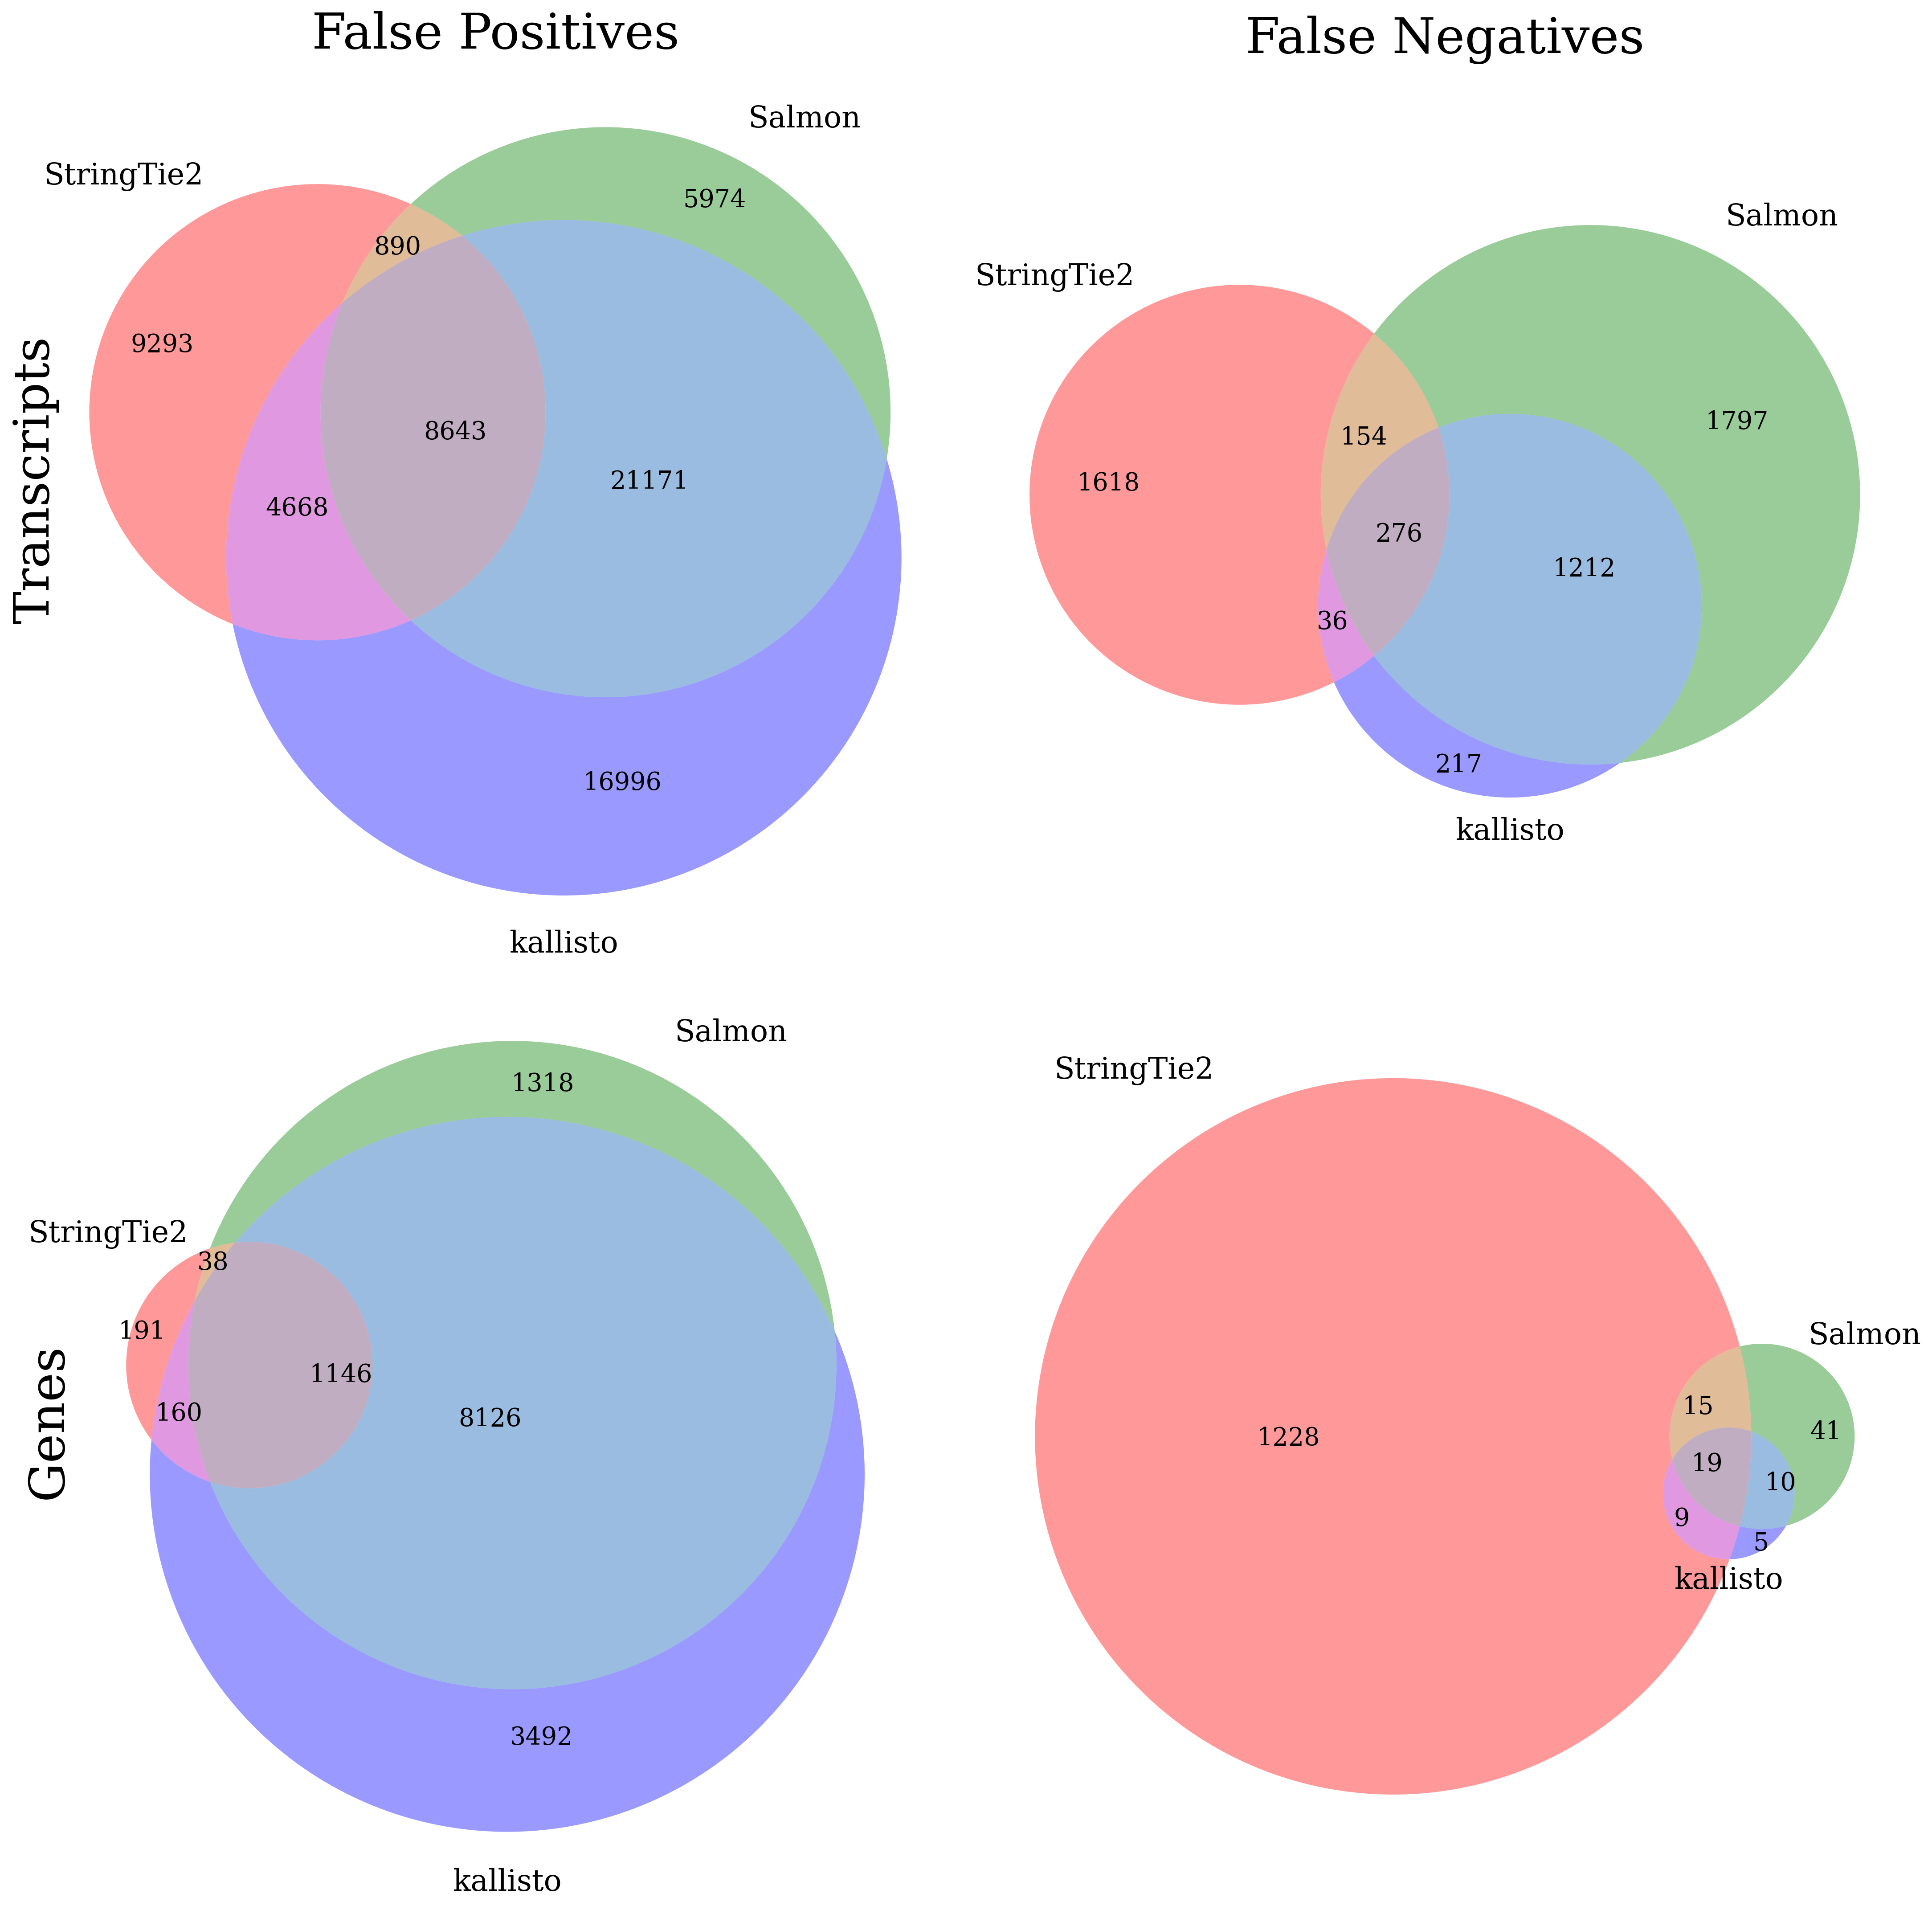

In [55]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(22,22),gridspec_kw={'hspace':0,'wspace':0},dpi=250)

labels = ("StringTie2","Salmon","kallisto")

v = venn3(subsets={"100":strg_only_tx_fp_avg,
                   "010":slmn_only_tx_fp_avg,
                   "001":klst_only_tx_fp_avg,
                   "110":strg_slmn_tx_fp_avg,
                   "101":strg_klst_tx_fp_avg,
                   "011":slmn_klst_tx_fp_avg,
                   "111":strg_slmn_klst_tx_fp_avg},set_labels=labels,ax=axes[0][0])
axes[0][0].set_title("False Positives",fontsize=32)
axes[0][0].text(-0.75,0, 'Transcripts', va='center', rotation='vertical',fontsize=32)

v = venn3(subsets={"100":strg_only_tx_fn_avg,
                   "010":slmn_only_tx_fn_avg,
                   "001":klst_only_tx_fn_avg,
                   "110":strg_slmn_tx_fn_avg,
                   "101":strg_klst_tx_fn_avg,
                   "011":slmn_klst_tx_fn_avg,
                   "111":strg_slmn_klst_tx_fn_avg},set_labels=labels,ax=axes[0][1])
axes[0][1].set_title("False Negatives",y=1.15,fontsize=32)

v = venn3(subsets={"100":strg_only_gn_fp_avg,
                   "010":slmn_only_gn_fp_avg,
                   "001":klst_only_gn_fp_avg,
                   "110":strg_slmn_gn_fp_avg,
                   "101":strg_klst_gn_fp_avg,
                   "011":slmn_klst_gn_fp_avg,
                   "111":strg_slmn_klst_gn_fp_avg},set_labels=labels,ax=axes[1][0])
axes[1][0].text(-0.7,0, 'Genes', va='center', rotation='vertical',fontsize=32)

v = venn3(subsets={"100":strg_only_gn_fn_avg,
                   "010":slmn_only_gn_fn_avg,
                   "001":klst_only_gn_fn_avg,
                   "110":strg_slmn_gn_fn_avg,
                   "101":strg_klst_gn_fn_avg,
                   "011":slmn_klst_gn_fn_avg,
                   "111":strg_slmn_klst_gn_fn_avg},set_labels=labels,ax=axes[1][1])

plt.show()

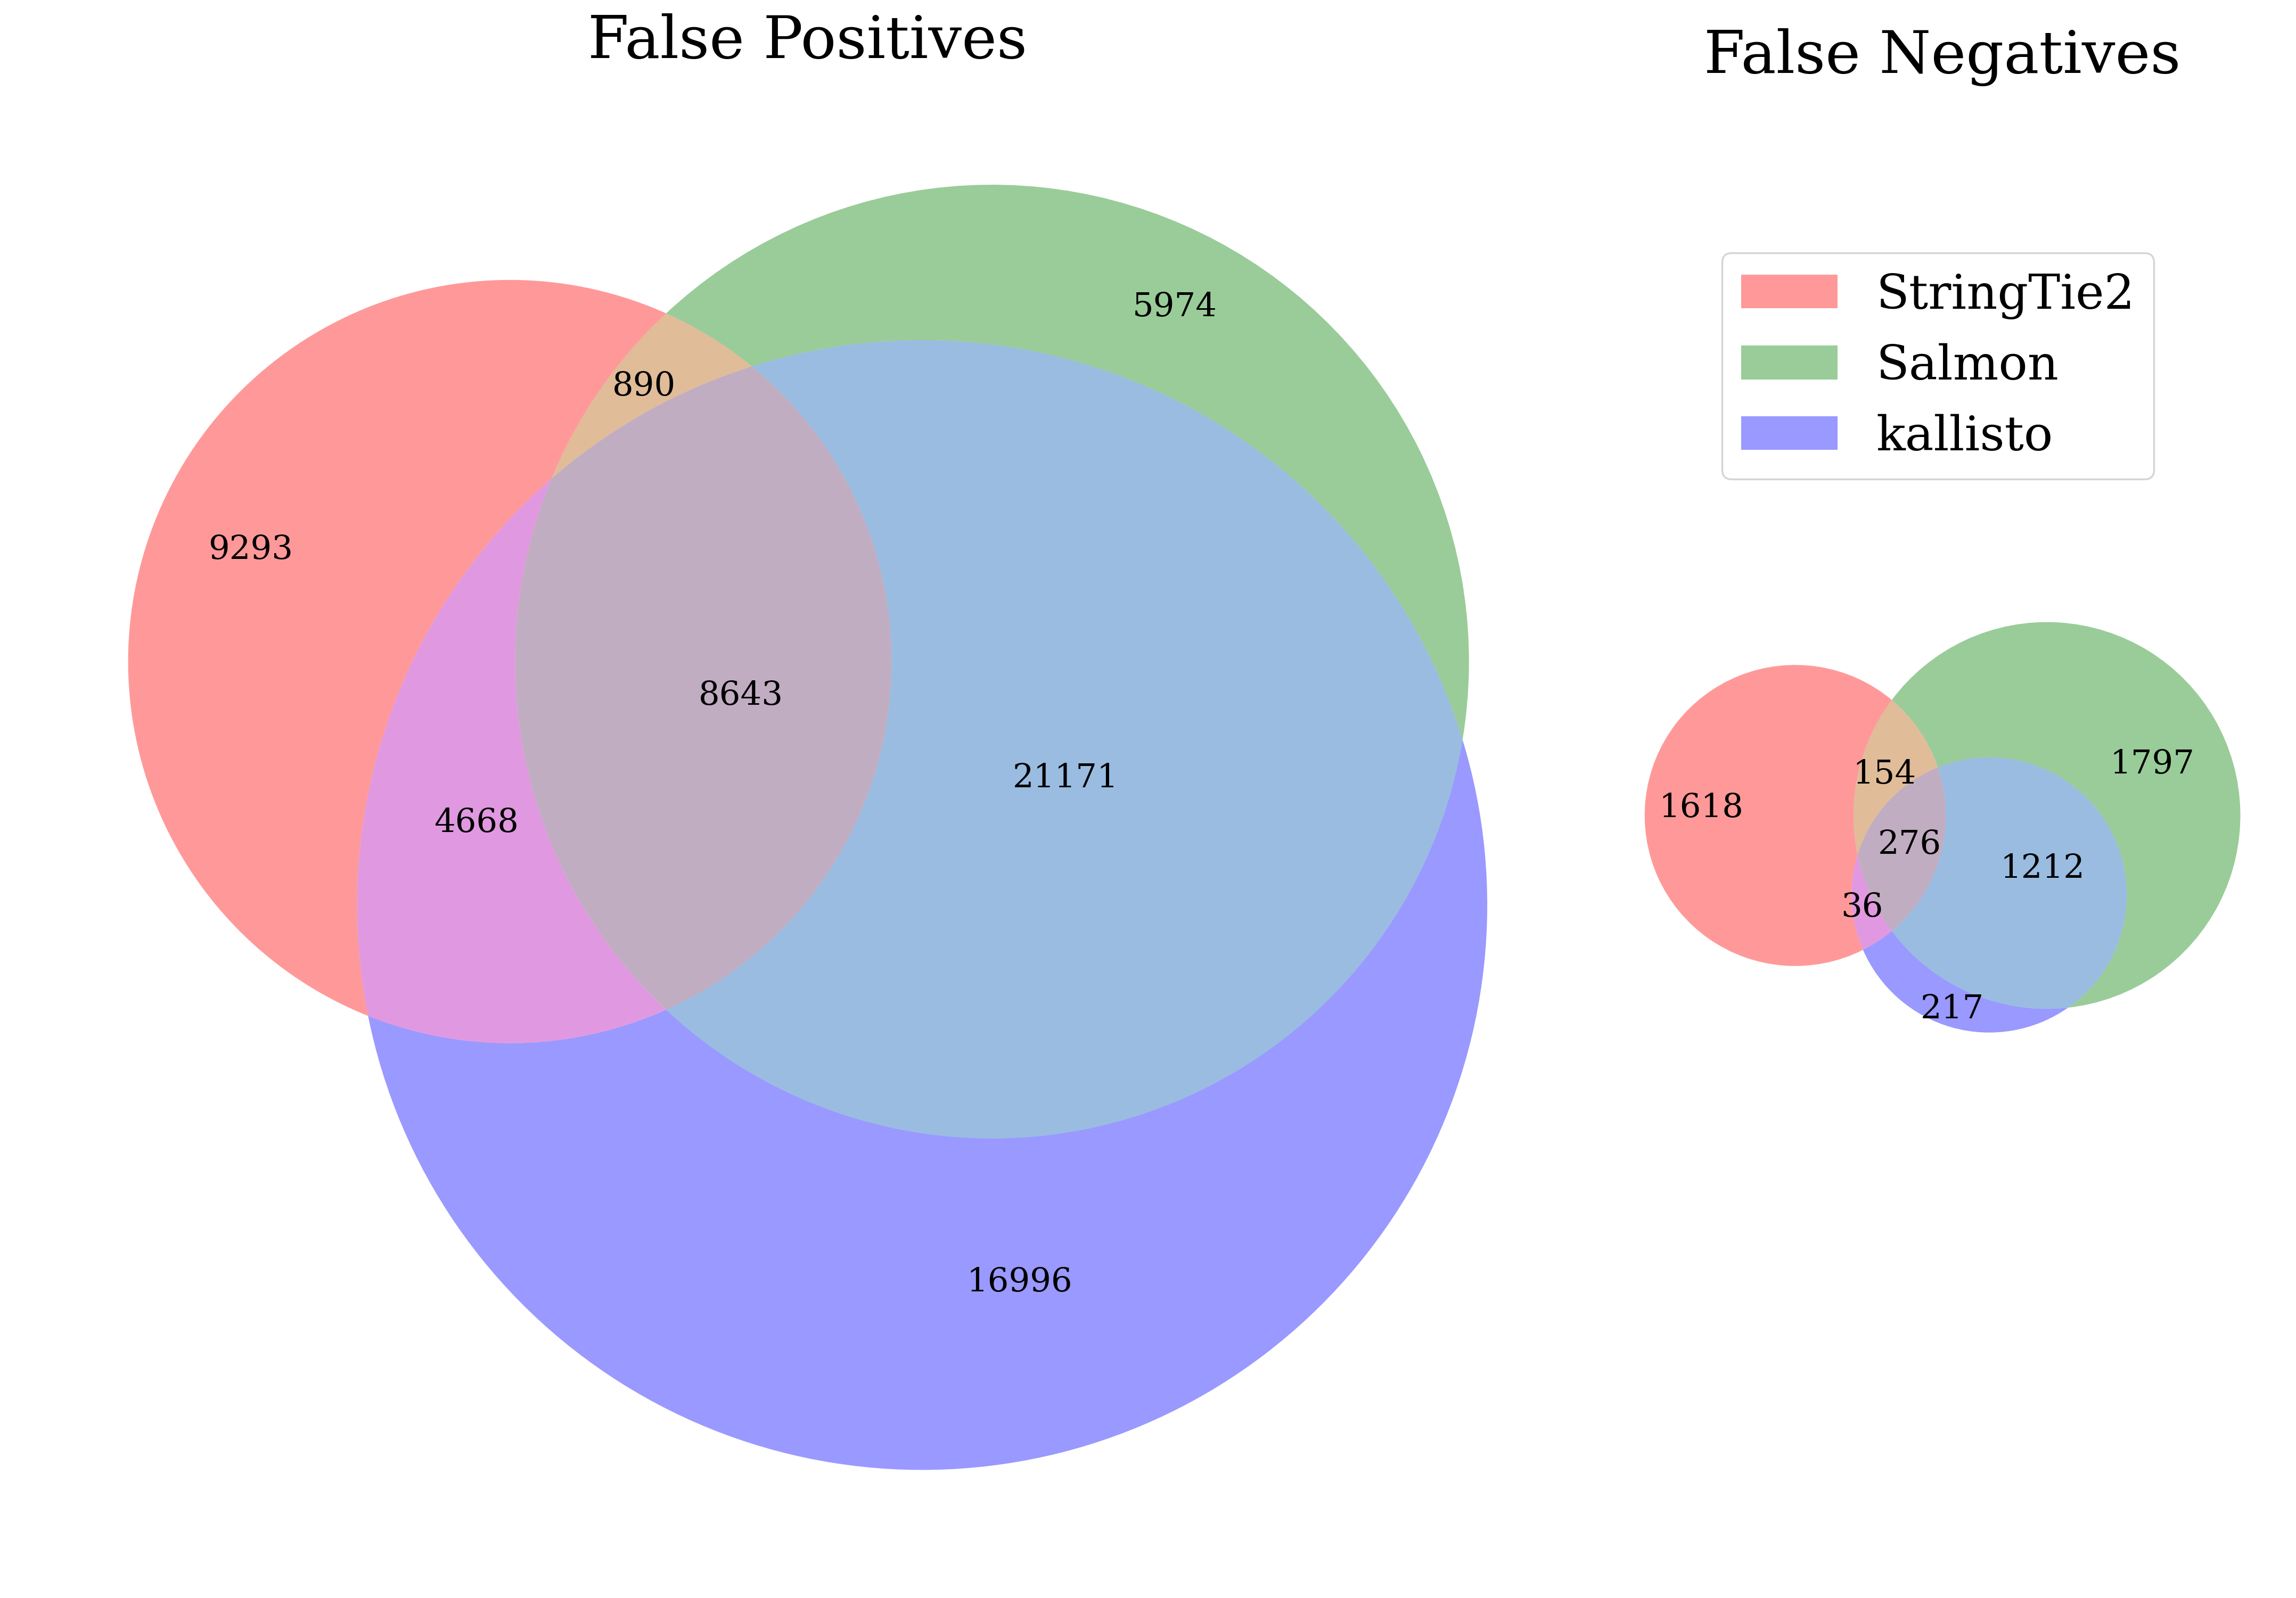

In [56]:
plt.rcParams['font.size'] = 18

wr = 70

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(22,22),gridspec_kw={'hspace':0,'wspace':0,"width_ratios":[wr,100-wr]},dpi=250)

labels = ("StringTie2","Salmon","kallisto")

sets = {"100":strg_only_tx_fp_avg,
       "010":slmn_only_tx_fp_avg,
       "001":klst_only_tx_fp_avg,
       "110":strg_slmn_tx_fp_avg,
       "101":strg_klst_tx_fp_avg,
       "011":slmn_klst_tx_fp_avg,
       "111":strg_slmn_klst_tx_fp_avg}
v = venn3(subsets=sets,set_labels=["","",""],ax=axes[0])
axes[0].set_title("False Positives",fontsize=32)

sets = {"100":strg_only_tx_fn_avg,
       "010":slmn_only_tx_fn_avg,
       "001":klst_only_tx_fn_avg,
       "110":strg_slmn_tx_fn_avg,
       "101":strg_klst_tx_fn_avg,
       "011":slmn_klst_tx_fn_avg,
       "111":strg_slmn_klst_tx_fn_avg}
v = venn3(subsets=sets,set_labels=["","",""],ax=axes[1])
axes[1].set_title("False Negatives",y=2,fontsize=32)

h, l = [],[]
counter = 0
for i in sets:
    if i in ["100","010","001"]:
        h.append(v.get_patch_by_id(i))
        l.append(labels[counter])
        counter+=1

fig.legend(handles=h,labels=l,loc=(0.75,0.7),fontsize=26)

plt.show()

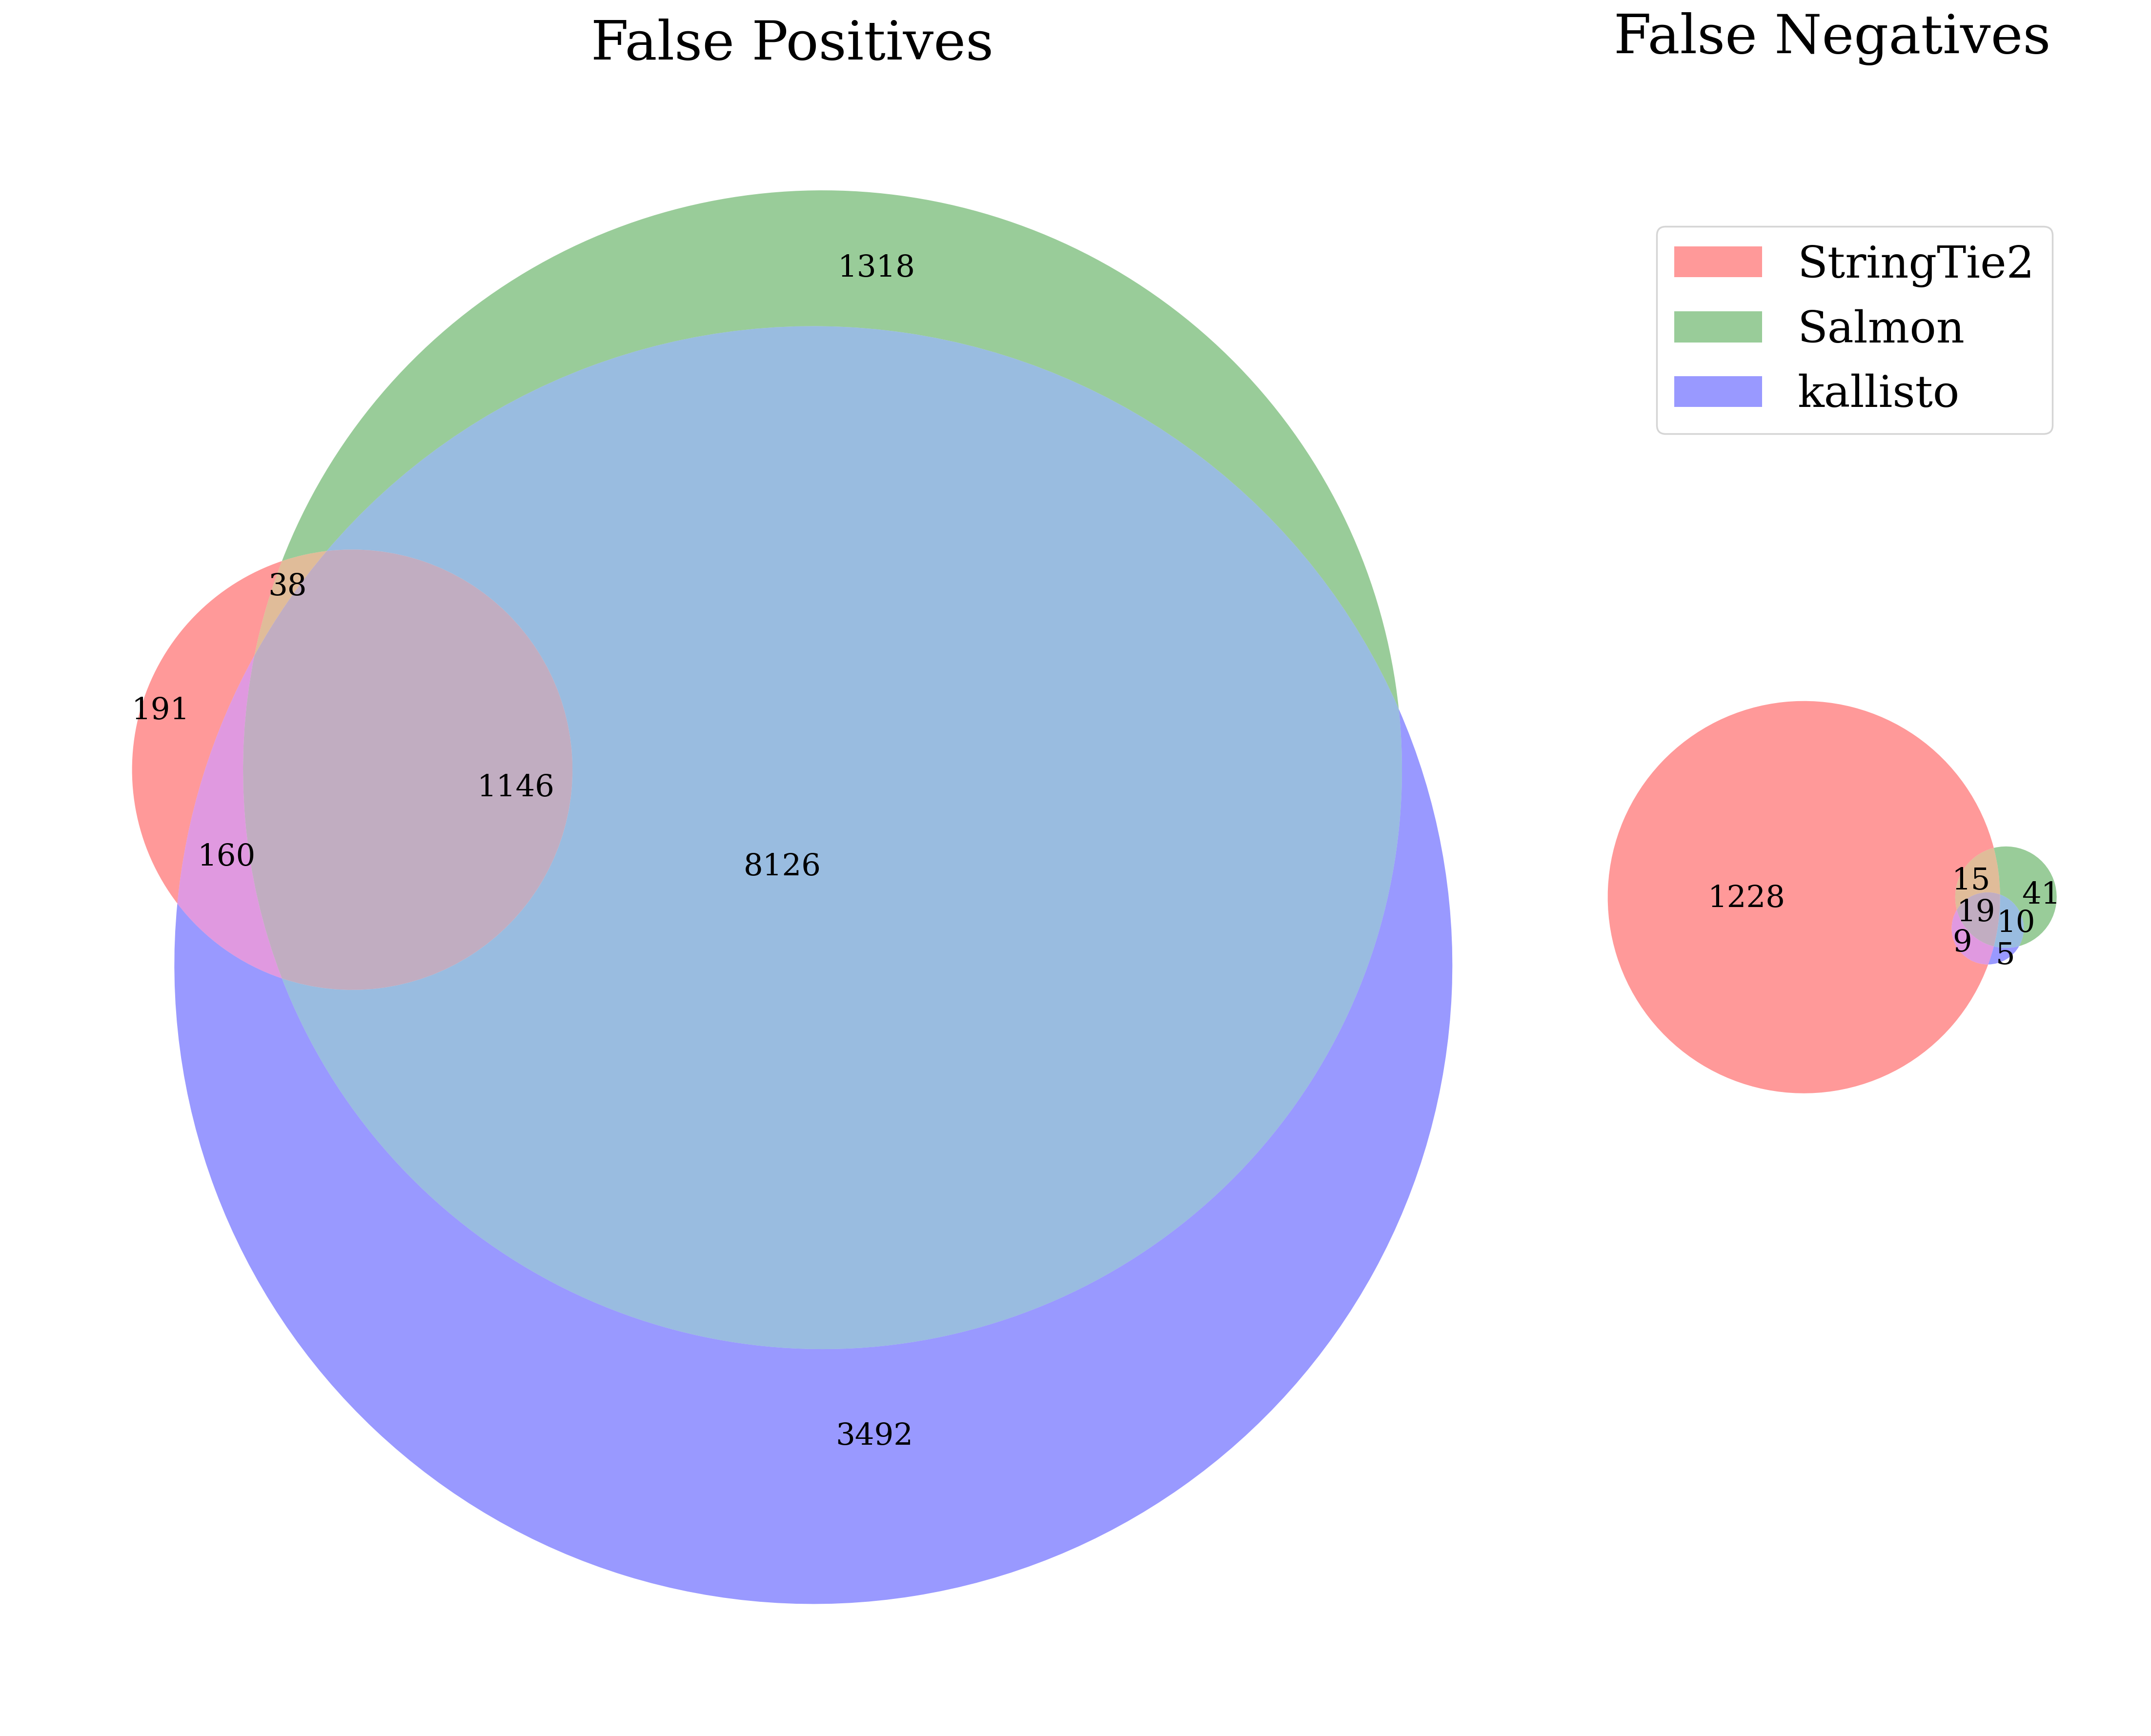

In [57]:
plt.rcParams['font.size'] = 18

wr = 75

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(22,22),gridspec_kw={'hspace':0,'wspace':0,"width_ratios":[wr,100-wr]},dpi=250)

labels = ("StringTie2","Salmon","kallisto")

sets = {"100":strg_only_gn_fp_avg,
       "010":slmn_only_gn_fp_avg,
       "001":klst_only_gn_fp_avg,
       "110":strg_slmn_gn_fp_avg,
       "101":strg_klst_gn_fp_avg,
       "011":slmn_klst_gn_fp_avg,
       "111":strg_slmn_klst_gn_fp_avg}
v = venn3(subsets=sets,set_labels=["","",""],ax=axes[0])
axes[0].set_title("False Positives",fontsize=32)
# axes[0].text(-0.7,0, 'Genes', va='center', rotation='vertical',fontsize=32)

sets = {"100":strg_only_gn_fn_avg,
       "010":slmn_only_gn_fn_avg,
       "001":klst_only_gn_fn_avg,
       "110":strg_slmn_gn_fn_avg,
       "101":strg_klst_gn_fn_avg,
       "011":slmn_klst_gn_fn_avg,
       "111":strg_slmn_klst_gn_fn_avg}
v = venn3(subsets=sets,set_labels=["","",""],ax=axes[1])
axes[1].set_title("False Negatives",y=2.3,fontsize=32)

h, l = [],[]
counter = 0
for i in sets:
    if i in ["100","010","001"]:
        h.append(v.get_patch_by_id(i))
        l.append(labels[counter])
        counter+=1

fig.legend(handles=h,labels=l,loc=(0.77,0.75),fontsize=26)

plt.show()

Text(0.5, 0, 'Number of Samples')

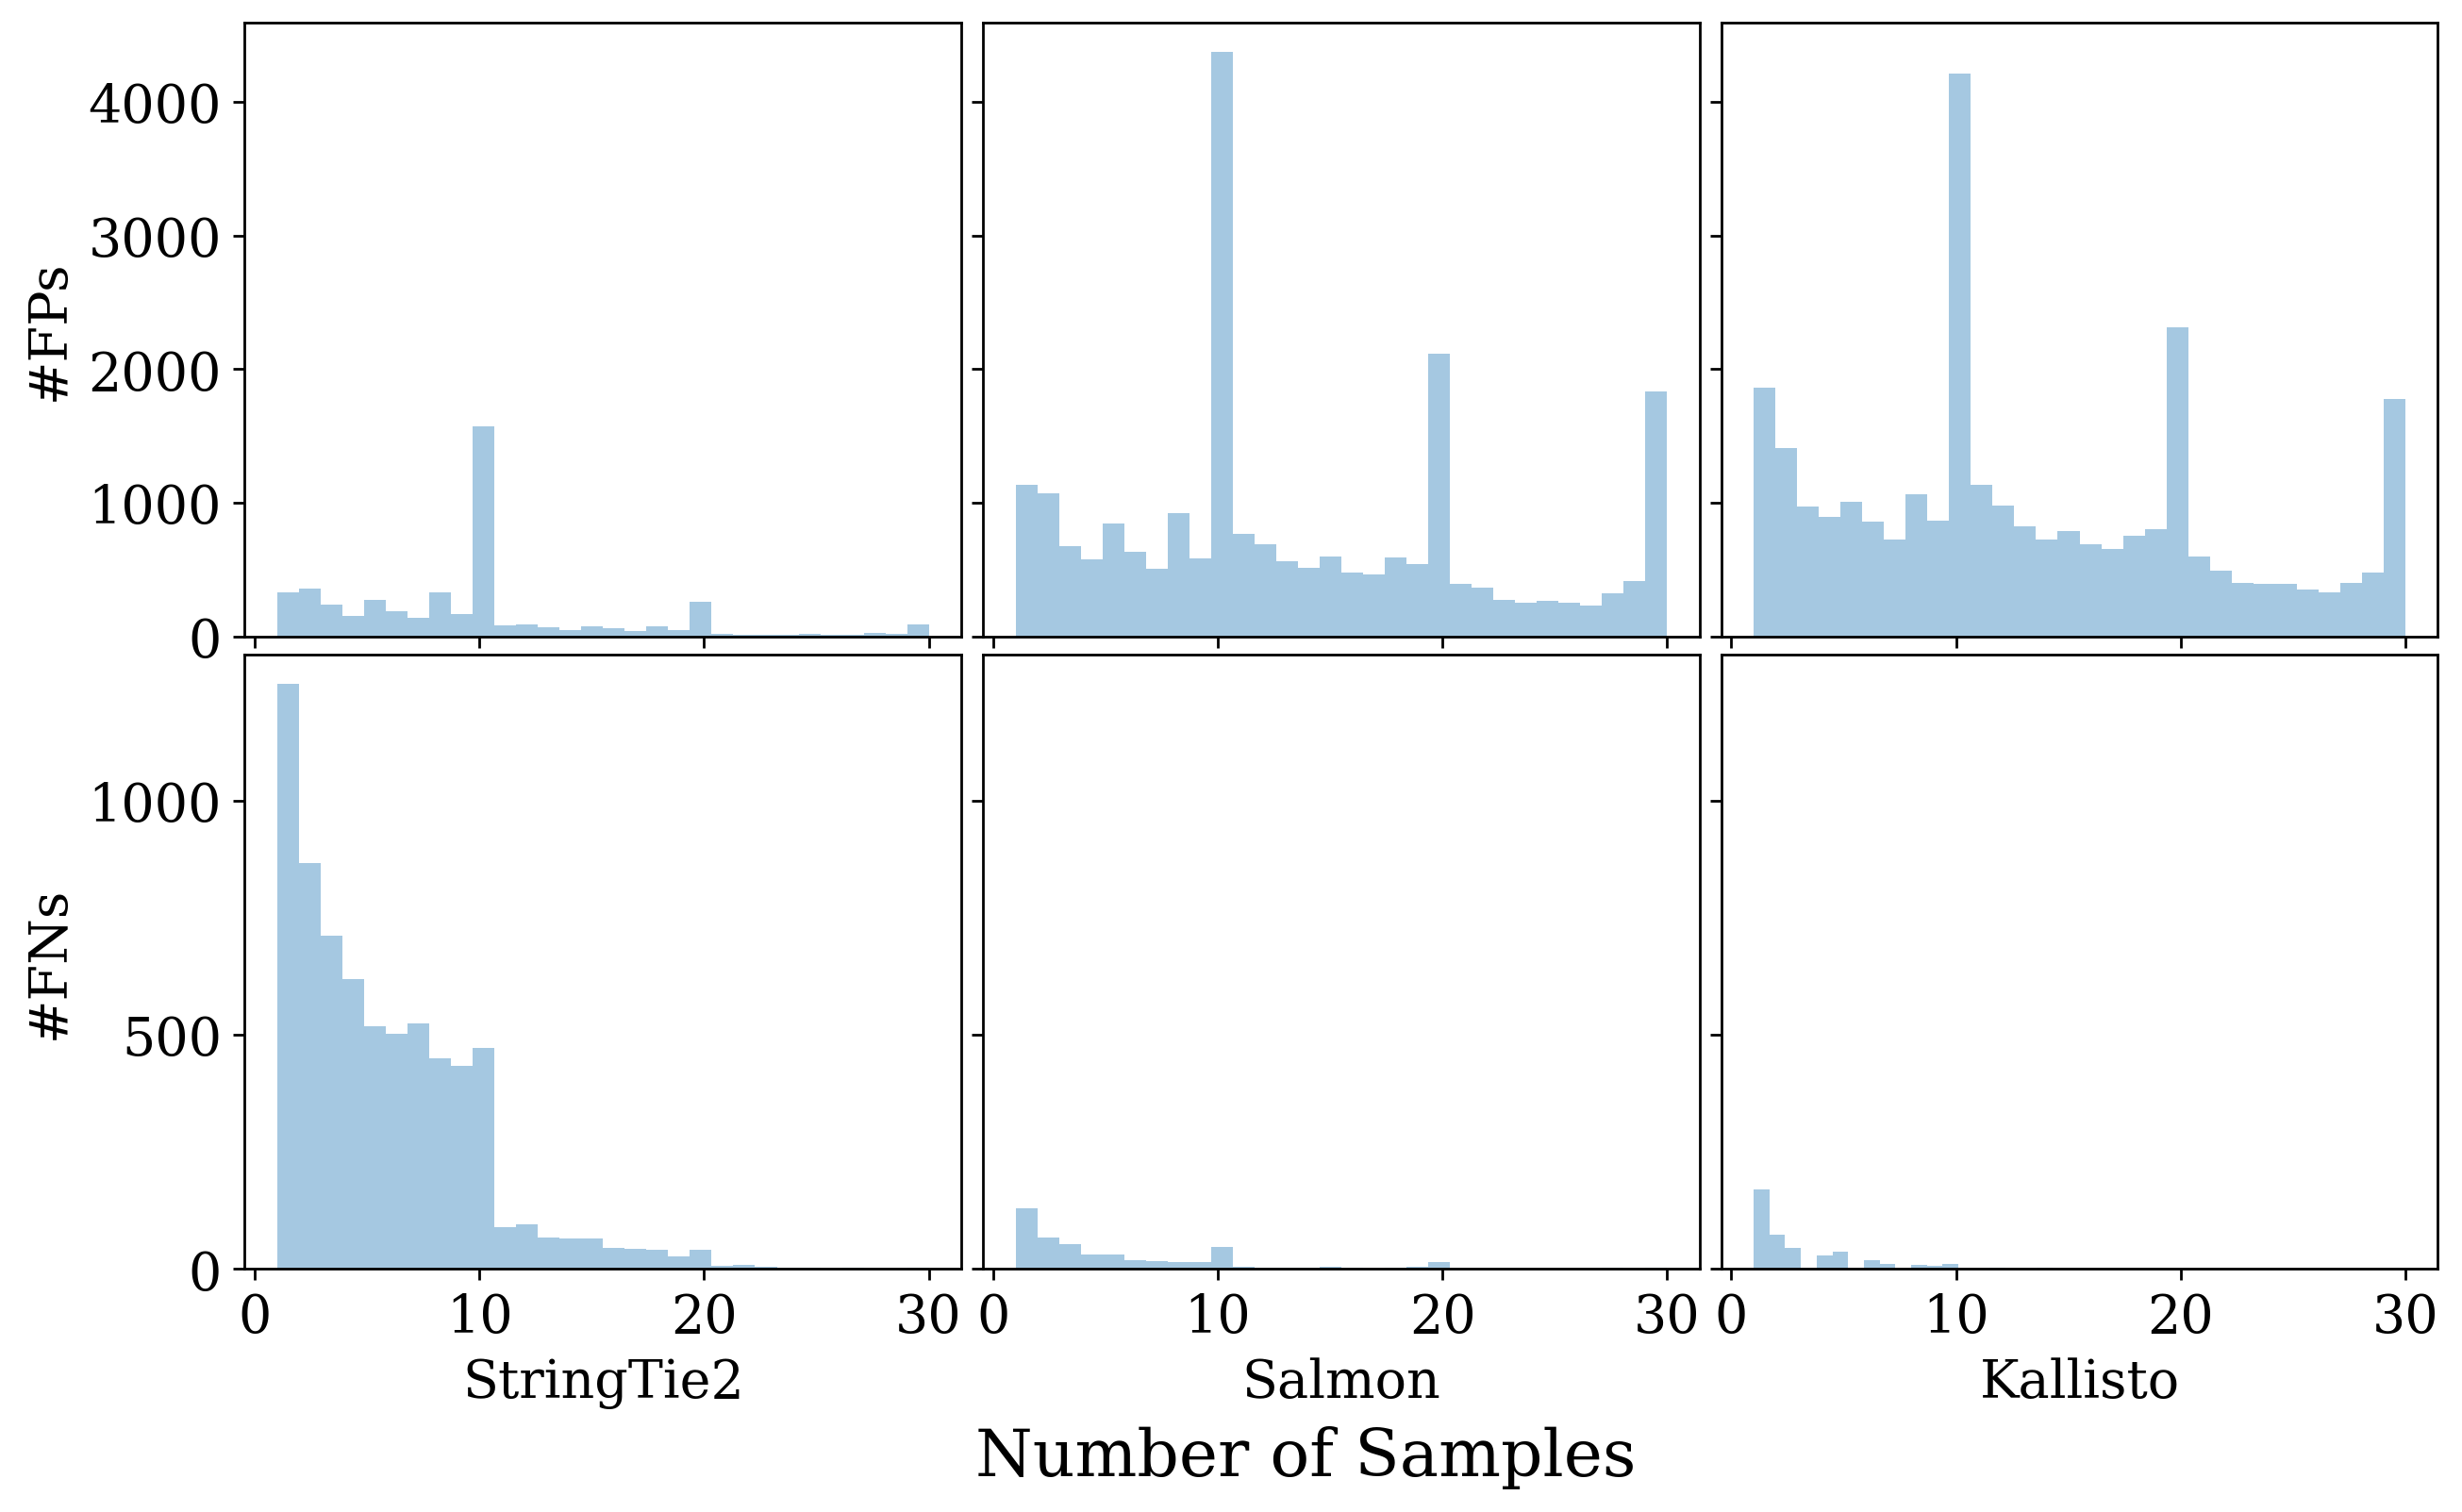

In [58]:
# now to compute the histograms

gn_fp_hist_strg = pd.DataFrame()
gn_fp_hist_slmn = pd.DataFrame()
gn_fp_hist_klst = pd.DataFrame()

gn_fn_hist_strg = pd.DataFrame()
gn_fn_hist_slmn = pd.DataFrame()
gn_fn_hist_klst = pd.DataFrame()

for tn in range(num_tissues):
    for sn in range(num_samples):
        gn_fp_hist_strg = pd.concat([gn_fp_hist_strg,pd.read_csv(out_dir+"fp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")[["gid","sim_nreads"]]])
        gn_fp_hist_slmn = pd.concat([gn_fp_hist_slmn,pd.read_csv(out_dir+"fp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")[["gid","sim_nreads"]]])
        gn_fp_hist_klst = pd.concat([gn_fp_hist_klst,pd.read_csv(out_dir+"fp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")[["gid","sim_nreads"]]])
        
        gn_fn_hist_strg = pd.concat([gn_fn_hist_strg,pd.read_csv(out_dir+"fn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")[["gid","sim_nreads"]]])
        gn_fn_hist_slmn = pd.concat([gn_fn_hist_slmn,pd.read_csv(out_dir+"fn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")[["gid","sim_nreads"]]])
        gn_fn_hist_klst = pd.concat([gn_fn_hist_klst,pd.read_csv(out_dir+"fn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")[["gid","sim_nreads"]]])
        
gn_fp_hist_strg = gn_fp_hist_strg.groupby(by="gid").count().reset_index()
gn_fp_hist_strg.columns = ["gid","count"]
gn_fp_hist_slmn = gn_fp_hist_slmn.groupby(by="gid").count().reset_index()
gn_fp_hist_slmn.columns = ["gid","count"]
gn_fp_hist_klst = gn_fp_hist_klst.groupby(by="gid").count().reset_index()
gn_fp_hist_klst.columns = ["gid","count"]


gn_fn_hist_strg = gn_fn_hist_strg.groupby(by="gid").count().reset_index()
gn_fn_hist_strg.columns = ["gid","count"]
gn_fn_hist_slmn = gn_fn_hist_slmn.groupby(by="gid").count().reset_index()
gn_fn_hist_slmn.columns = ["gid","count"]
gn_fn_hist_klst = gn_fn_hist_klst.groupby(by="gid").count().reset_index()
gn_fn_hist_klst.columns = ["gid","count"]



plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,7),sharex=True,sharey="row",gridspec_kw={'hspace':0.03,'wspace':0.03},dpi=250)

sns.distplot(gn_fp_hist_strg["count"],bins=30,kde=False,ax=axes[0][0])
sns.distplot(gn_fp_hist_slmn["count"],bins=30,kde=False,ax=axes[0][1])
sns.distplot(gn_fp_hist_klst["count"],bins=30,kde=False,ax=axes[0][2])

sns.distplot(gn_fn_hist_strg["count"],bins=30,kde=False,ax=axes[1][0])
sns.distplot(gn_fn_hist_slmn["count"],bins=30,kde=False,ax=axes[1][1])
sns.distplot(gn_fn_hist_klst["count"],bins=30,kde=False,ax=axes[1][2])

axes[0][0].set_ylabel("#FPs")
axes[1][0].set_ylabel("#FNs")

axes[1][0].set_xlabel("StringTie2")
axes[1][1].set_xlabel("Salmon")
axes[1][2].set_xlabel("Kallisto")
fig.text(0.5, 0, "Number of Samples", ha='center',fontsize=20)

In [59]:
# now need to plot false positives and false negatives
strg_real = []
slmn_real = []
klst_real = []

strg_all = []
slmn_all = []
klst_all = []

for tn in range(num_tissues):
    for sn in range(num_samples):
        strg_real.append([len(pd.read_csv(out_dir+"fp_strg_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"fn_strg_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"tp_strg_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"tn_strg_real.t"+str(tn)+"_s"+str(sn)+".csv"))])
        slmn_real.append([len(pd.read_csv(out_dir+"fp_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"fn_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"tp_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"tn_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv"))])
        klst_real.append([len(pd.read_csv(out_dir+"fp_klst_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"fn_klst_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"tp_klst_real.t"+str(tn)+"_s"+str(sn)+".csv")),
                          len(pd.read_csv(out_dir+"tn_klst_real.t"+str(tn)+"_s"+str(sn)+".csv"))])

        strg_all.append([len(pd.read_csv(out_dir+"fp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"fn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"tp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"tn_strg_all.t"+str(tn)+"_s"+str(sn)+".csv"))])
        slmn_all.append([len(pd.read_csv(out_dir+"fp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"fn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"tp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"tn_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv"))])
        klst_all.append([len(pd.read_csv(out_dir+"fp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"fn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"tp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")),
                         len(pd.read_csv(out_dir+"tn_klst_all.t"+str(tn)+"_s"+str(sn)+".csv"))])

In [63]:
tmp = pd.DataFrame(strg_real,columns=["fp","fn","tp","tn"])
tmp["method"] = "StringTie2"
tmp["type"] = "Real"
df = tmp.copy(deep=True)
tmp = pd.DataFrame(strg_all,columns=["fp","fn","tp","tn"])
tmp["method"] = "StringTie2"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(slmn_real,columns=["fp","fn","tp","tn"])
tmp["method"] = "Salmon"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(slmn_all,columns=["fp","fn","tp","tn"])
tmp["method"] = "Salmon"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

tmp = pd.DataFrame(klst_real,columns=["fp","fn","tp","tn"])
tmp["method"] = "kallisto"
tmp["type"] = "Real"
df = pd.concat([df,tmp],axis=0)
tmp = pd.DataFrame(klst_all,columns=["fp","fn","tp","tn"])
tmp["method"] = "kallisto"
tmp["type"] = "All"
df = pd.concat([df,tmp],axis=0)

df.reset_index(drop=True)
df["fpr"] = df["fp"]/(df["fp"]+df["tn"])
df["fnr"] = df["fn"]/(df["fn"]+df["tp"])
df.head()

,fp,fn,tp,tn,method,type,fpr,fnr
0,714,1155,12780,28119,StringTie2,Real,0.024763,0.082885
1,643,1046,10948,30131,StringTie2,Real,0.020894,0.087210
2,616,1193,9391,31568,StringTie2,Real,0.019140,0.112717
3,636,1408,11077,29647,StringTie2,Real,0.021002,0.112775
4,676,1479,12106,28507,StringTie2,Real,0.023164,0.108870


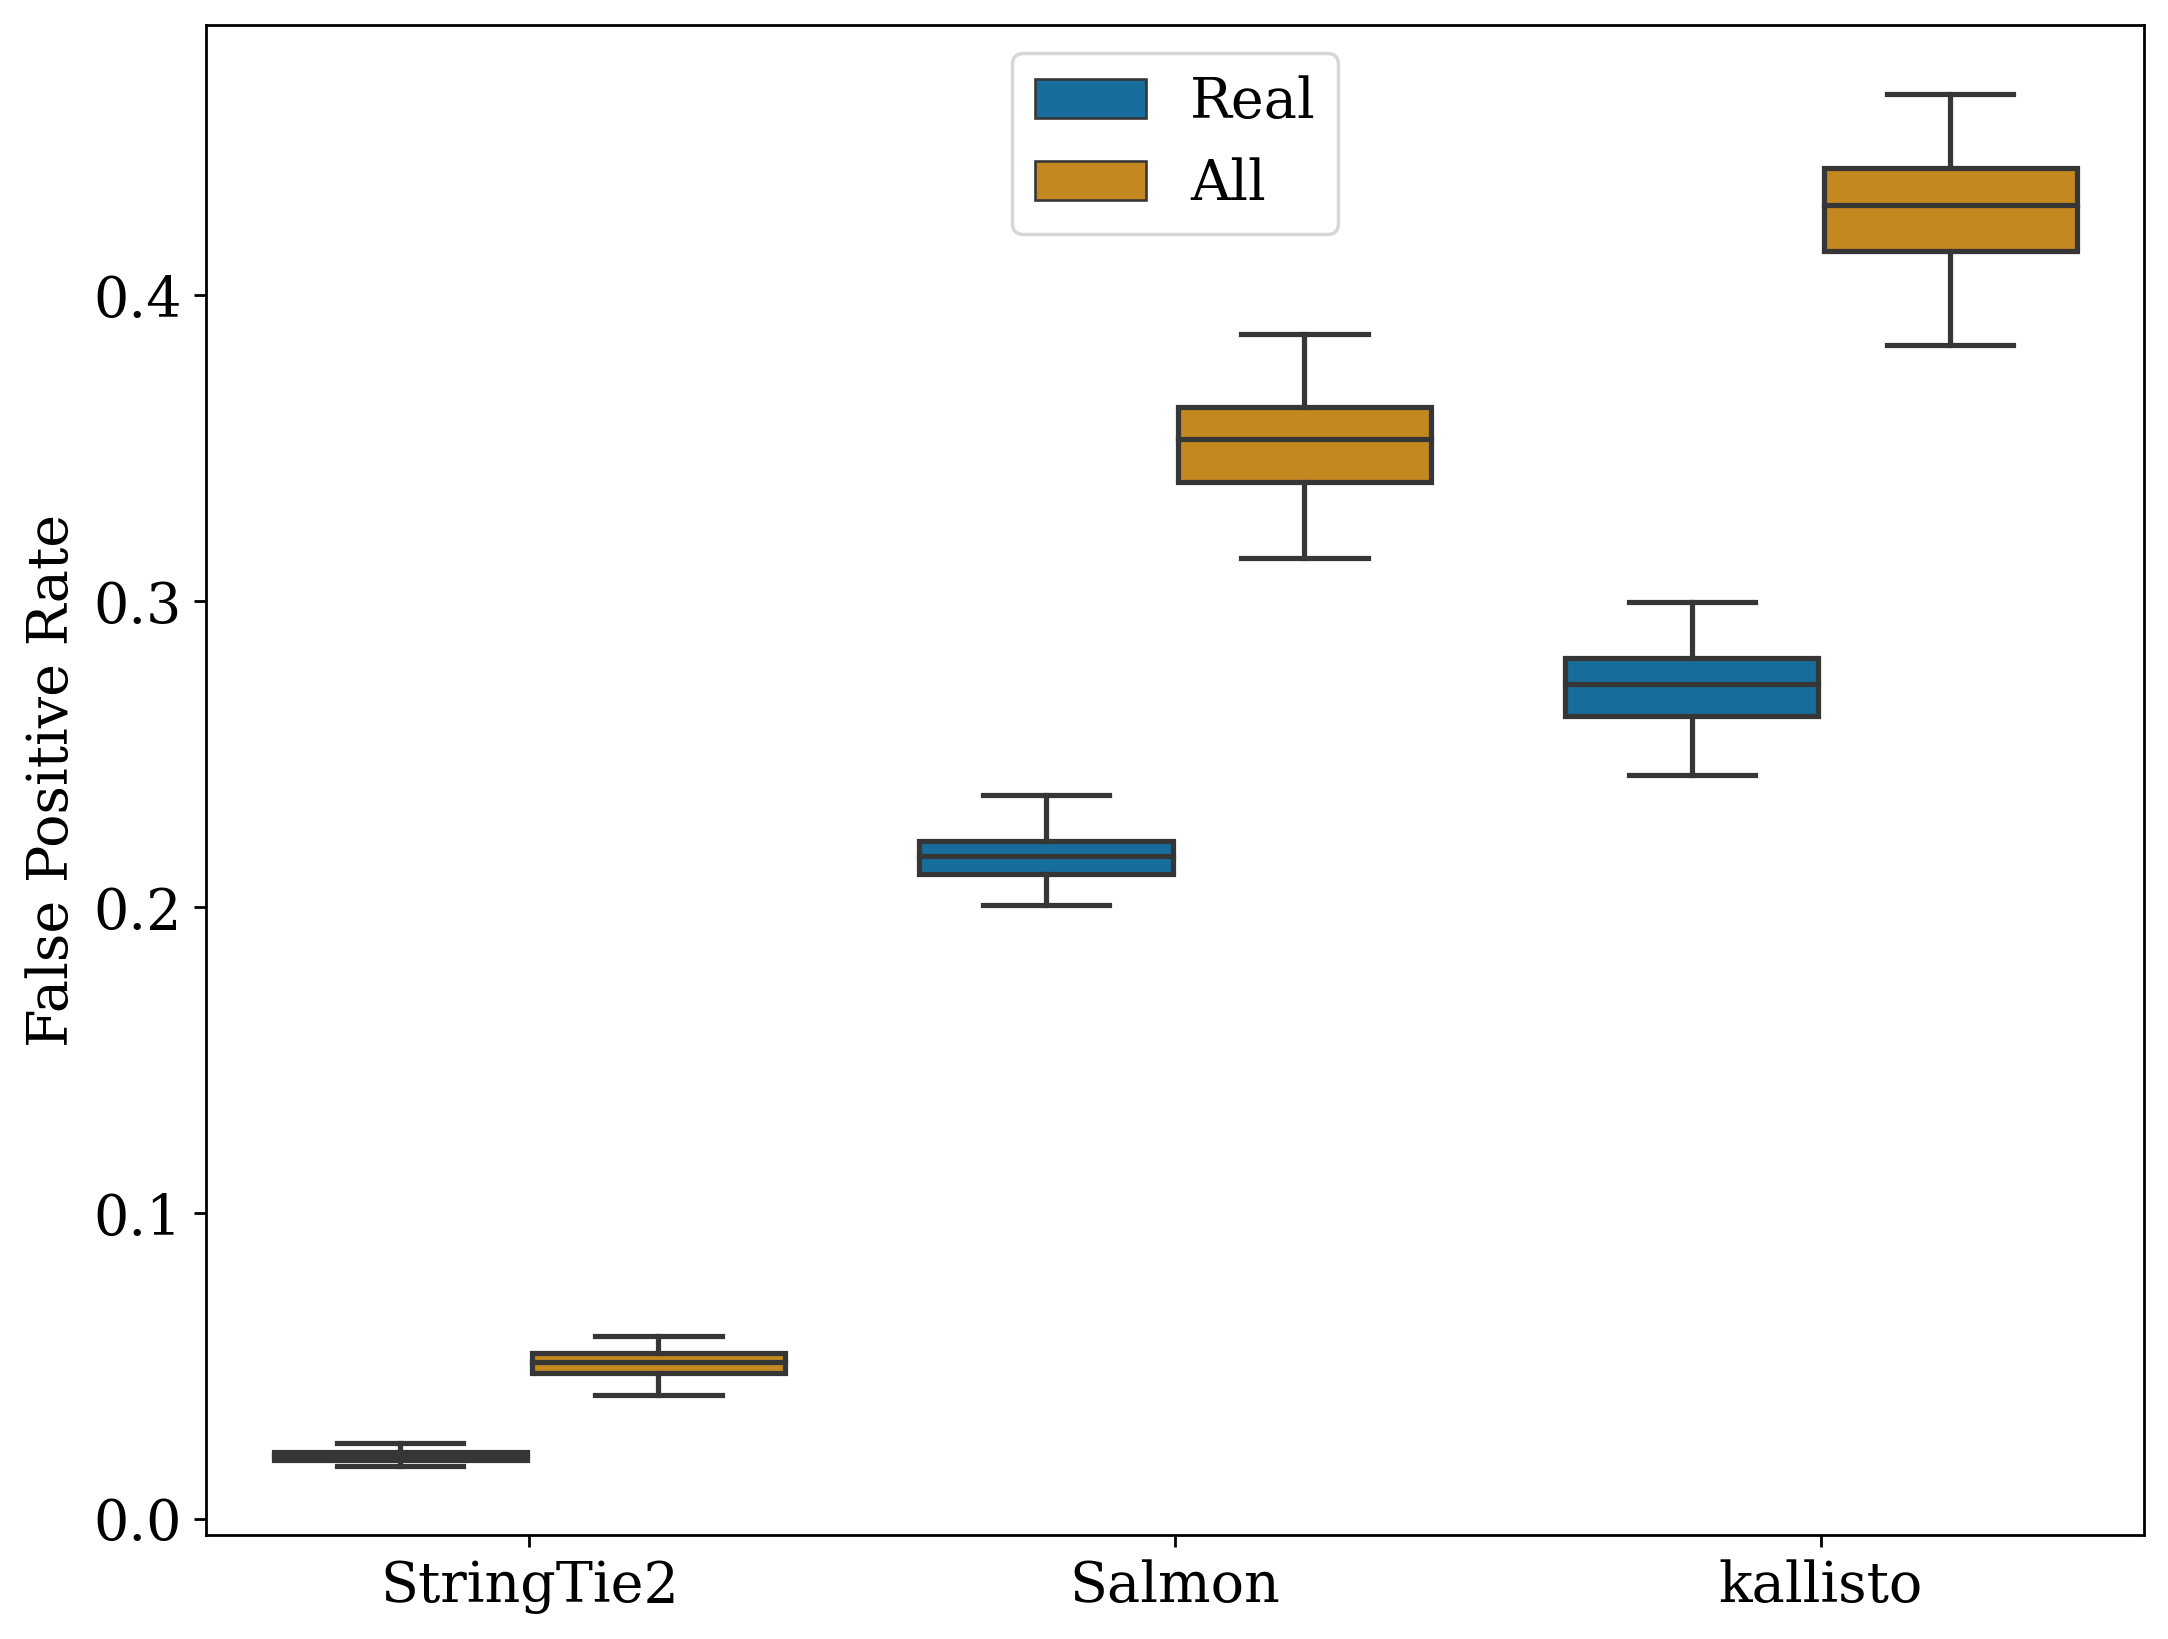

In [64]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="fpr",hue="type",data=df,palette=[custom_palette[0],custom_palette[4]])
# ax.set_title("Number of non-simulated transcripts (false positives) \n reported as expressed")
ax.set_xlabel("")
ax.set_ylabel("False Positive Rate")
legend = plt.legend(loc="upper center")
fig.savefig(fig_dir+"fpr_genes_all.png", format='png')
plt.show()

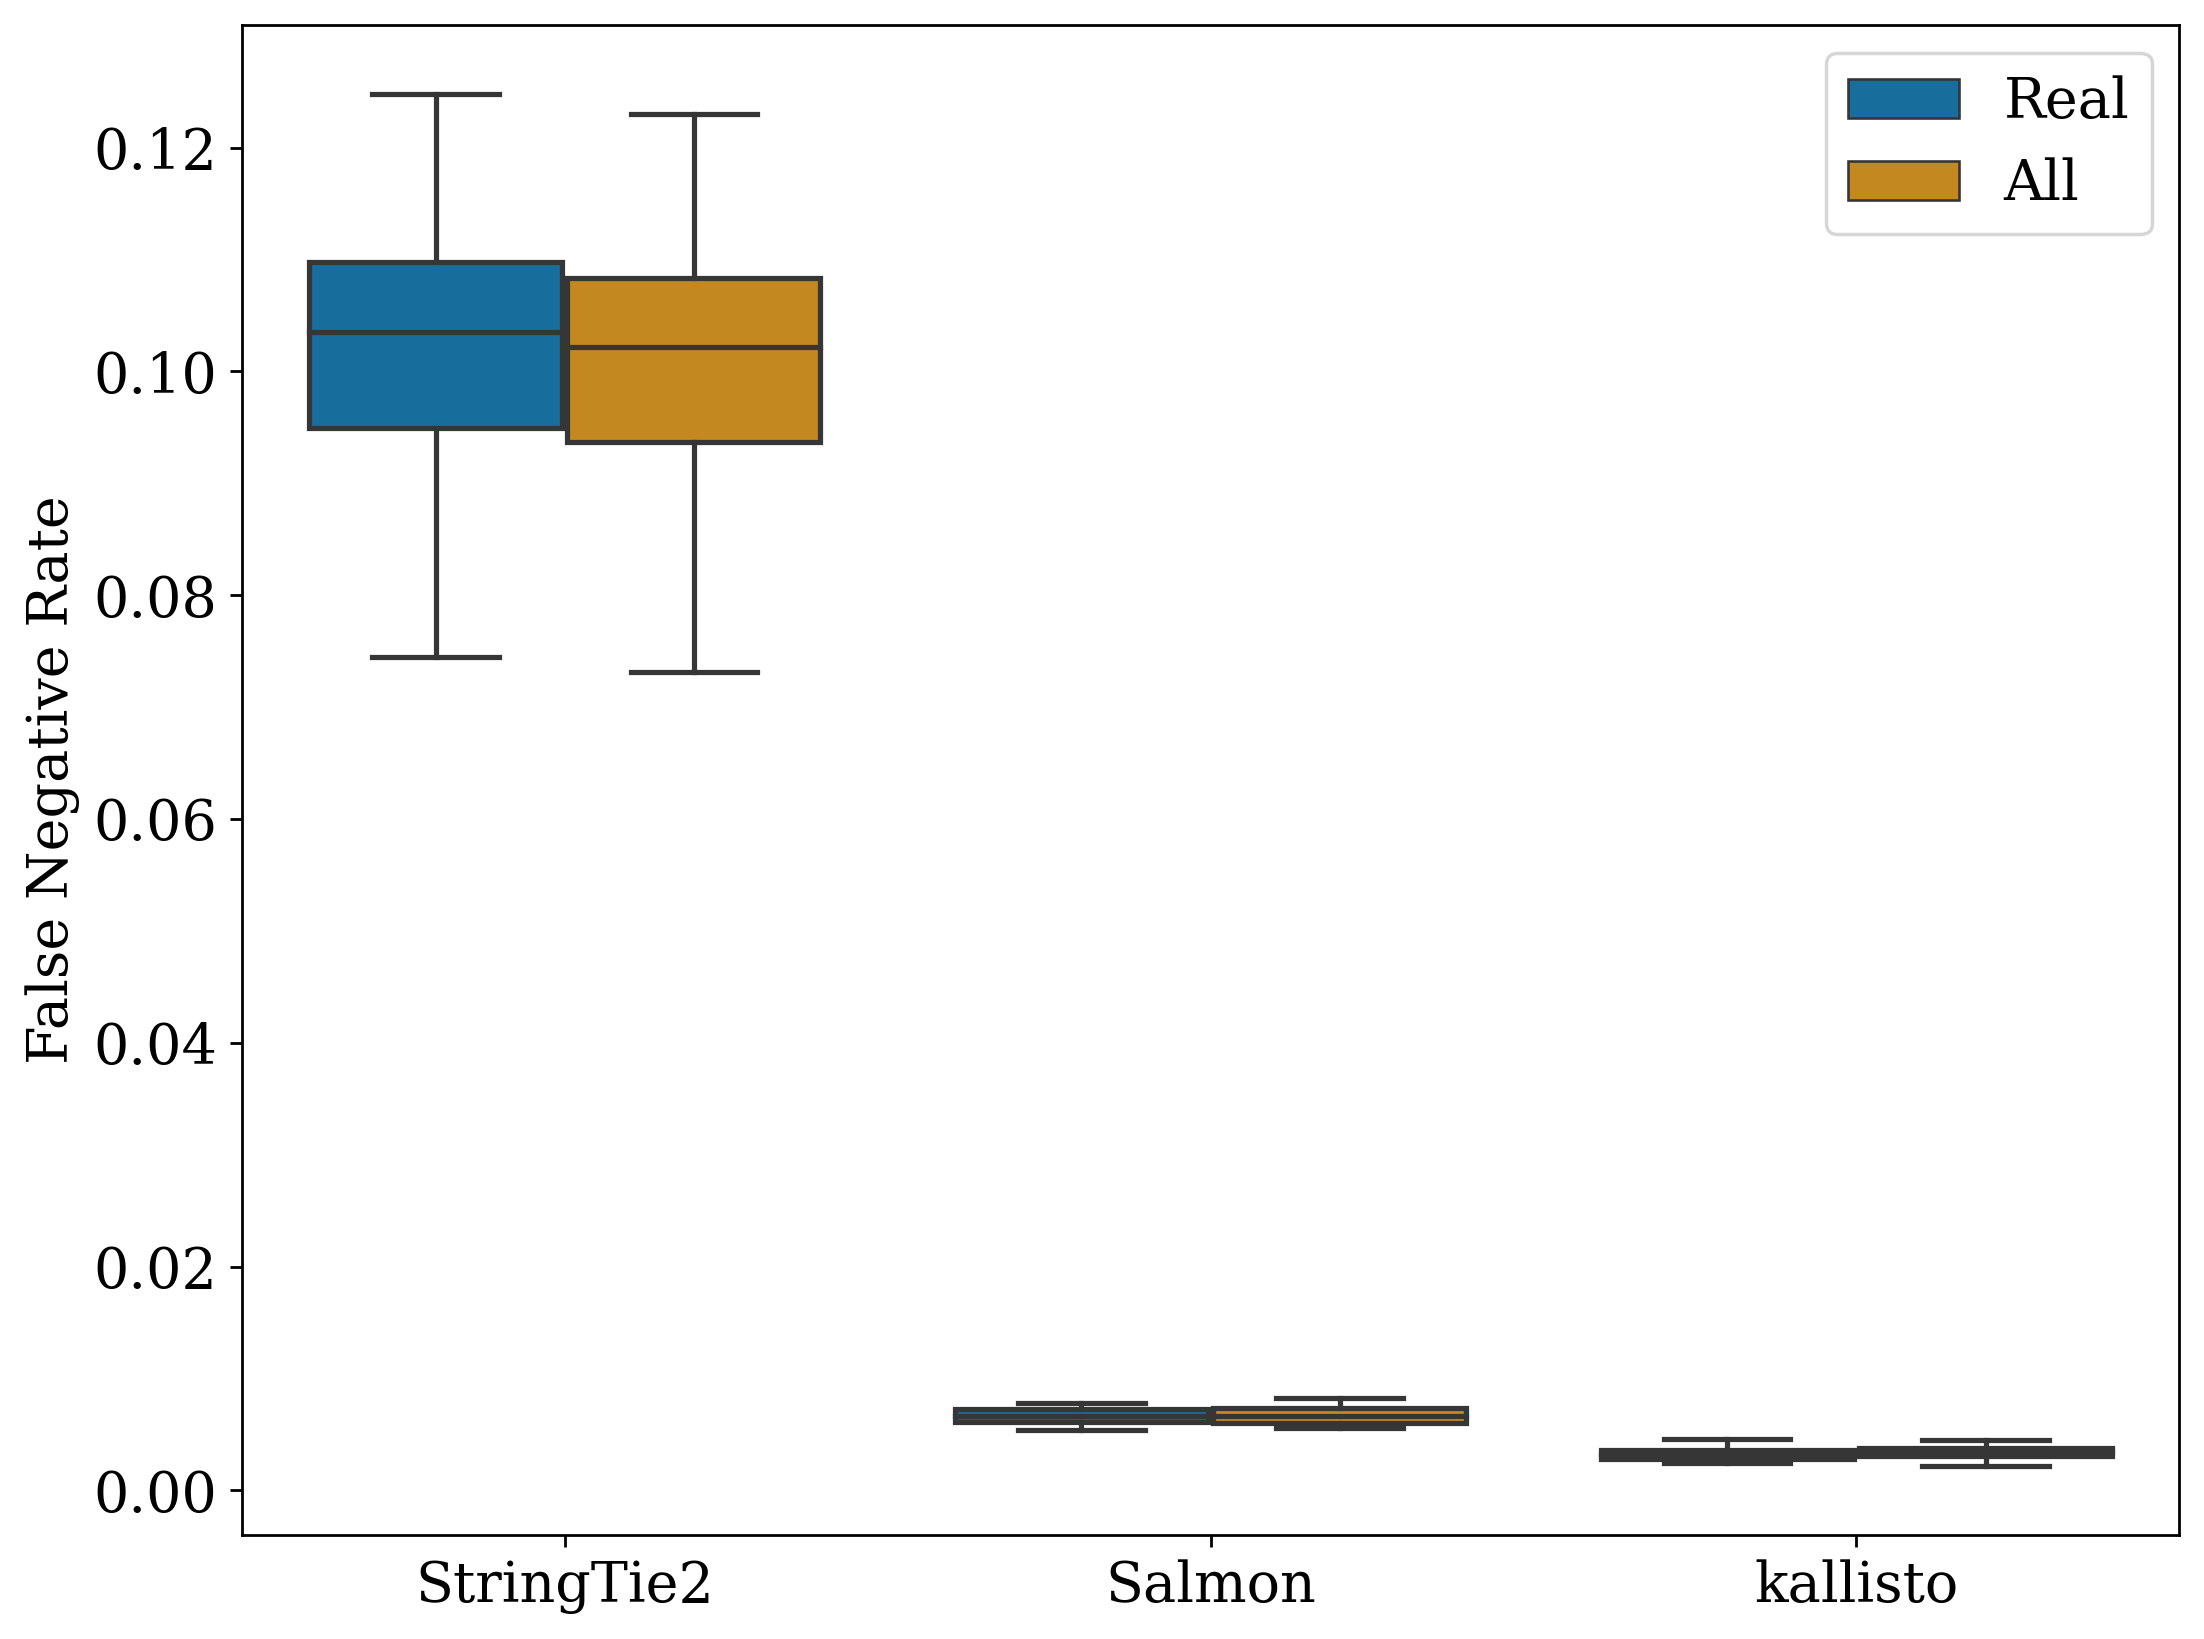

In [65]:
plt.rcParams['font.size'] = 16
fig = plt.figure(figsize=(10,8),dpi=250)
ax = sns.boxplot(x="method",y="fnr",hue="type",data=df,palette=[custom_palette[0],custom_palette[4]])
# ax.set_title("Number of non-simulated transcripts (false positives) \n reported as expressed")
ax.set_xlabel("")
ax.set_ylabel("False Negative Rate")
legend = plt.legend(loc="upper right")
fig.savefig(fig_dir+"fnr_genes_all.png", format='png')
plt.show()

In [ ]:
# lastly we need scatter plots for abundance (simulated #reads vs estimated #reads)

strg_real_tpm = pd.DataFrame()
slmn_real_tpm = pd.DataFrame()
klst_real_tpm = pd.DataFrame()

strg_all_tpm = pd.DataFrame()
slmn_all_tpm = pd.DataFrame()
klst_all_tpm = pd.DataFrame()

for tn in range(num_tissues):
    for sn in range(num_samples):
        tmp = pd.read_csv(out_dir+"tp_strg_real.t"+str(tn)+"_s"+str(sn)+".csv")[["sim_nreads","strg_nreads_real"]]
        tmp = tmp[(tmp["sim_nreads"]>=1)&(tmp["strg_nreads_real"]>=1)].reset_index(drop=True)
        strg_real_tpm = pd.concat([strg_real_tpm,tmp])
        tmp = pd.read_csv(out_dir+"tp_slmn_real.t"+str(tn)+"_s"+str(sn)+".csv")[["sim_nreads","slmn_nreads_real"]]
        tmp = tmp[(tmp["sim_nreads"]>=1)&(tmp["slmn_nreads_real"]>=1)].reset_index(drop=True)
        slmn_real_tpm = pd.concat([slmn_real_tpm,tmp])
        tmp = pd.read_csv(out_dir+"tp_klst_real.t"+str(tn)+"_s"+str(sn)+".csv")[["sim_nreads","klst_nreads_real"]]
        tmp = tmp[(tmp["sim_nreads"]>=1)&(tmp["klst_nreads_real"]>=1)].reset_index(drop=True)
        klst_real_tpm = pd.concat([klst_real_tpm,tmp])
        
        tmp = pd.read_csv(out_dir+"tp_strg_all.t"+str(tn)+"_s"+str(sn)+".csv")[["sim_nreads","strg_nreads_all"]]
        tmp = tmp[(tmp["sim_nreads"]>=1)&(tmp["strg_nreads_all"]>=1)].reset_index(drop=True)
        strg_all_tpm = pd.concat([strg_all_tpm,tmp])
        tmp = pd.read_csv(out_dir+"tp_slmn_all.t"+str(tn)+"_s"+str(sn)+".csv")[["sim_nreads","slmn_nreads_all"]]
        tmp = tmp[(tmp["sim_nreads"]>=1)&(tmp["slmn_nreads_all"]>=1)].reset_index(drop=True)
        slmn_all_tpm = pd.concat([slmn_all_tpm,tmp])
        tmp = pd.read_csv(out_dir+"tp_klst_all.t"+str(tn)+"_s"+str(sn)+".csv")[["sim_nreads","klst_nreads_all"]]
        tmp = tmp[(tmp["sim_nreads"]>=1)&(tmp["klst_nreads_all"]>=1)].reset_index(drop=True)
        klst_all_tpm = pd.concat([klst_all_tpm,tmp])
        
strg_real_tpm

In [ ]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,7),sharex=False,sharey="row",gridspec_kw={'hspace':0.03,'wspace':0.03},dpi=250)

minmax_sim = [min(strg_real_tpm["sim_nreads"]),max(strg_real_tpm["sim_nreads"])]

sns.scatterplot(data=strg_real_tpm, x="sim_nreads", y="strg_nreads_real",ax=axes[0][0],alpha=0.025,color=custom_palette[0])
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[0][0],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=strg_real_tpm["sim_nreads"],y=strg_real_tpm["strg_nreads_real"])
axes[0][0].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)
axes[0][0].set_yscale("log")
axes[0][0].set_xscale("log")
sns.scatterplot(data=slmn_real_tpm, x="sim_nreads", y="slmn_nreads_real",ax=axes[0][1],alpha=0.025,color=custom_palette[0])
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[0][1],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=slmn_real_tpm["sim_nreads"],y=slmn_real_tpm["slmn_nreads_real"])
axes[0][1].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)
axes[0][1].set_yscale("log")
axes[0][1].set_xscale("log")
sns.scatterplot(data=klst_real_tpm, x="sim_nreads", y="klst_nreads_real",ax=axes[0][2],alpha=0.025,color=custom_palette[0])
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[0][2],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=klst_real_tpm["sim_nreads"],y=klst_real_tpm["klst_nreads_real"])
axes[0][2].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)
axes[0][2].set_yscale("log")
axes[0][2].set_xscale("log")


sns.scatterplot(data=strg_all_tpm, x="sim_nreads", y="strg_nreads_all",ax=axes[1][0],alpha=0.025,color=custom_palette[0])
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[1][0],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=strg_all_tpm["sim_nreads"],y=strg_all_tpm["strg_nreads_all"])
axes[1][0].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)
axes[1][0].set_yscale("log")
axes[1][0].set_xscale("log")
sns.scatterplot(data=slmn_all_tpm, x="sim_nreads", y="slmn_nreads_all",ax=axes[1][1],alpha=0.025,color=custom_palette[0])
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[1][1],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=slmn_all_tpm["sim_nreads"],y=slmn_all_tpm["slmn_nreads_all"])
axes[1][1].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)
axes[1][1].set_yscale("log")
axes[1][1].set_xscale("log")
sns.scatterplot(data=klst_all_tpm, x="sim_nreads", y="klst_nreads_all",ax=axes[1][2],alpha=0.025,color=custom_palette[0])
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[1][2],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=klst_all_tpm["sim_nreads"],y=klst_all_tpm["klst_nreads_all"])
axes[1][2].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)
axes[1][2].set_yscale("log")
axes[1][2].set_xscale("log")

axes[1][1].set_xlabel("Simulated Number of Reads",fontsize=20)
axes[1][0].set_xlabel("")
axes[1][2].set_xlabel("")
axes[0][0].set_ylabel("No Noise")
axes[1][0].set_ylabel("With Noise")
axes[0][0].set_title("StringTie2")
axes[0][1].set_title("Salmon")
axes[0][2].set_title("kallisto")

fig.text(0.04, 0.5, 'Estimated Number of Reads', va='center', rotation='vertical',fontsize=20)

In [ ]:
readlen=101

strg_df = pd.DataFrame()
slmn_df = pd.DataFrame()
klst_df = pd.DataFrame()

for tn in range(tissue_num):
    for sn in range(sample_num):
        real_tmp = pd.read_csv(out_dir+"real.t"+str(tissue_num)+"_s"+str(sample_num)+".res")
        all_tmp = pd.read_csv(out_dir+"all.t"+str(tissue_num)+"_s"+str(sample_num)+".res")


        real_tmp["sim_cov"] = (readlen*real_tmp["sim_nreads"])/real_tmp["elen_true"]
        all_tmp["sim_cov"] = (readlen*all_tmp["sim_nreads"])/all_tmp["elen_true"]

        # merge and compute fold_change in TPM
        merge_tmp = real_tmp[["tid","sim_nreads","sim_cov","sim_tpm","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]].merge(all_tmp[["tid","strg_tpm","strg_nreads","slmn_tpm","slmn_nreads","klst_tpm","klst_nreads"]],on="tid",how="inner")
        assert len(merge_tmp)==len(real_tmp),"lost transcripts during merge"
        merge_tmp.columns = ["tid",
                            "sim_nreads",
                            "sim_cov",
                            "sim_tpm",
                            "strg_tpm_real",
                            "strg_nreads_real",
                            "slmn_tpm_real",
                            "slmn_nreads_real",
                            "klst_tpm_real",
                            "klst_nreads_real",
                            "strg_tpm_all",
                            "strg_nreads_all",
                            "slmn_tpm_all",
                            "slmn_nreads_all",
                            "klst_tpm_all",
                            "klst_nreads_all"]

        strg_tmp = merge_tmp[(merge_tmp["sim_nreads"]>=1)&(merge_tmp["strg_nreads_real"]>=1)&(merge_tmp["strg_nreads_all"]>=1)][["tid","sim_nreads","strg_nreads_real","strg_nreads_all","sim_tpm","strg_tpm_real","strg_tpm_all"]].reset_index(drop=True)
        slmn_tmp = merge_tmp[(merge_tmp["sim_nreads"]>=1)&(merge_tmp["slmn_nreads_real"]>=1)&(merge_tmp["slmn_nreads_all"]>=1)][["tid","sim_nreads","slmn_nreads_real","slmn_nreads_all","sim_tpm","slmn_tpm_real","slmn_tpm_all"]].reset_index(drop=True)
        klst_tmp = merge_tmp[(merge_tmp["sim_nreads"]>=1)&(merge_tmp["klst_nreads_real"]>=1)&(merge_tmp["klst_nreads_all"]>=1)][["tid","sim_nreads","klst_nreads_real","klst_nreads_all","sim_tpm","klst_tpm_real","klst_tpm_all"]].reset_index(drop=True)
        strg_tmp["strg_fold_all"] = ((strg_tmp["strg_tpm_all"]-strg_tmp["strg_tpm_real"])/strg_tmp["strg_tpm_real"])*100
        slmn_tmp["slmn_fold_all"] = ((slmn_tmp["slmn_tpm_all"]-slmn_tmp["slmn_tpm_real"])/slmn_tmp["slmn_tpm_real"])*100
        klst_tmp["klst_fold_all"] = ((klst_tmp["klst_tpm_all"]-klst_tmp["klst_tpm_real"])/klst_tmp["klst_tpm_real"])*100

        strg_df = pd.concat([strg_df,strg_tmp]).reset_index(drop=True)
        slmn_df = pd.concat([slmn_df,slmn_tmp]).reset_index(drop=True)
        klst_df = pd.concat([klst_df,klst_tmp]).reset_index(drop=True)

In [ ]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(12,7),sharex=False,sharey="row",gridspec_kw={'hspace':0.03,'wspace':0.03},dpi=250)

sns.scatterplot(data=strg_df, x="sim_nreads", y="strg_nreads_real",ax=axes[0][0],alpha=0.025,color=custom_palette[0])
axes[0][0].set_yscale("log")
axes[0][0].set_xscale("log")
minmax_sim = [min(strg_df["sim_nreads"]),max(strg_df["sim_nreads"])]
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[0][0],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=strg_df["sim_nreads"],y=strg_df["strg_nreads_real"])
axes[0][0].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)

sns.scatterplot(data=slmn_df, x="sim_nreads", y="slmn_nreads_real",ax=axes[0][1],alpha=0.025,color=custom_palette[0])
axes[0][1].set_yscale("log")
axes[0][1].set_xscale("log")
minmax_sim = [min(slmn_df["sim_nreads"]),max(slmn_df["sim_nreads"])]
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[0][1],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=slmn_df["sim_nreads"],y=slmn_df["slmn_nreads_real"])
axes[0][1].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)

sns.scatterplot(data=klst_df, x="sim_nreads", y="klst_nreads_real",ax=axes[0][2],alpha=0.025,color=custom_palette[0])
axes[0][2].set_yscale("log")
axes[0][2].set_xscale("log")
minmax_sim = [min(klst_df["sim_nreads"]),max(klst_df["sim_nreads"])]
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[0][2],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=klst_df["sim_nreads"],y=klst_df["klst_nreads_real"])
axes[0][2].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)



sns.scatterplot(data=strg_df, x="sim_nreads", y="strg_nreads_all",ax=axes[1][0],alpha=0.025,color=custom_palette[0])
axes[1][0].set_yscale("log")
axes[1][0].set_xscale("log")
minmax_sim = [min(strg_df["sim_nreads"]),max(strg_df["sim_nreads"])]
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[1][0],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=strg_df["sim_nreads"],y=strg_df["strg_nreads_all"])
axes[1][0].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)

sns.scatterplot(data=slmn_df, x="sim_nreads", y="slmn_nreads_all",ax=axes[1][1],alpha=0.025,color=custom_palette[0])
axes[1][1].set_yscale("log")
axes[1][1].set_xscale("log")
minmax_sim = [min(slmn_df["sim_nreads"]),max(slmn_df["sim_nreads"])]
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[1][1],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=slmn_df["sim_nreads"],y=slmn_df["slmn_nreads_all"])
axes[1][1].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)

sns.scatterplot(data=klst_df, x="sim_nreads", y="klst_nreads_all",ax=axes[1][2],alpha=0.025,color=custom_palette[0])
axes[1][2].set_yscale("log")
axes[1][2].set_xscale("log")
minmax_sim = [min(klst_df["sim_nreads"]),max(klst_df["sim_nreads"])]
sns.lineplot(x=minmax_sim,y=minmax_sim,ax=axes[1][2],color=custom_palette[3],linewidth=2)
prval = scipy.stats.pearsonr(x=klst_df["sim_nreads"],y=klst_df["klst_nreads_all"])
axes[1][2].text(minmax_sim[1]/750,minmax_sim[1]/10,"$r^2$ = "+str(round(prval[0]**2,2)),fontsize=12)


axes[1][1].set_xlabel("Simulated Number of Reads",fontsize=20)
axes[1][0].set_xlabel("")
axes[1][2].set_xlabel("")
axes[0][0].set_ylabel("No Noise")
axes[1][0].set_ylabel("With Noise")
axes[0][0].set_title("StringTie2")
axes[0][1].set_title("Salmon")
axes[0][2].set_title("Kallisto")
fig.text(0.04, 0.5, 'Estimated Number of Reads', va='center', rotation='vertical',fontsize=20)